In [ ]:
"""
Trying Different Approach
Bayesian Football Model Implementation for Serie A 2007/08
Based on Baio & Blangiardo (2010)
"""

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


class BayesianFootballModel:
    """
    Implementation of Bayesian hierarchical model for football match prediction
    Adapted for Serie A 2007/08 dataset
    """

    def __init__(self, data):
        """
        Initialize the model with match data

        Parameters:
        -----------
        data : pd.DataFrame
            DataFrame with columns: 'hometeam_name', 'awayteam_name', 'y1', 'y2'
        """
        self.data = data
        self.n_games = len(data)

        # Create team mappings
        all_teams = pd.concat([data['hometeam_name'], data['awayteam_name']]).unique()
        self.n_teams = len(all_teams)
        self.team_to_idx = {team: idx for idx, team in enumerate(sorted(all_teams))}
        self.idx_to_team = {idx: team for team, idx in self.team_to_idx.items()}

        # Convert team names to indices
        self.home_idx = data['hometeam_name'].map(self.team_to_idx).values
        self.away_idx = data['awayteam_name'].map(self.team_to_idx).values
        self.home_goals = data['y1'].values
        self.away_goals = data['y2'].values

        print(f"Initialized model with {self.n_teams} teams and {self.n_games} matches")
        print(f"Teams: {', '.join(sorted(all_teams))}")

    def build_basic_model(self):
        """
        Build the basic hierarchical model (Section 2 of the paper)
        """
        with pm.Model() as model:
            # Home advantage effect
            home = pm.Normal('home', mu=0, sigma=100)  # Using sigma instead of tau

            # Hyperpriors for attack and defense
            mu_att = pm.Normal('mu_att', mu=0, sigma=100)
            mu_def = pm.Normal('mu_def', mu=0, sigma=100)
            sigma_att = pm.HalfNormal('sigma_att', sigma=10)
            sigma_def = pm.HalfNormal('sigma_def', sigma=10)

            # Team-specific effects with sum-to-zero constraint
            att_star = pm.Normal('att_star', mu=mu_att, sigma=sigma_att, shape=self.n_teams)
            def_star = pm.Normal('def_star', mu=mu_def, sigma=sigma_def, shape=self.n_teams)

            # Apply sum-to-zero constraint
            att = pm.Deterministic('att', att_star - att_star.mean())
            def_ = pm.Deterministic('def', def_star - def_star.mean())

            # Log-linear model for scoring intensities
            log_theta1 = home + att[self.home_idx] + def_[self.away_idx]
            log_theta2 = att[self.away_idx] + def_[self.home_idx]

            theta1 = pm.math.exp(log_theta1)
            theta2 = pm.math.exp(log_theta2)

            # Likelihood
            home_goals = pm.Poisson('home_goals', mu=theta1, observed=self.home_goals)
            away_goals = pm.Poisson('away_goals', mu=theta2, observed=self.away_goals)

            # For prediction
            home_goals_pred = pm.Poisson('home_goals_pred', mu=theta1, shape=self.n_games)
            away_goals_pred = pm.Poisson('away_goals_pred', mu=theta2, shape=self.n_games)

        return model

    def build_mixture_model(self, n_groups=3):
        """
        Build the mixture model to reduce overshrinkage (Section 4 of the paper)
        """
        with pm.Model() as model:
            # Home advantage effect
            home = pm.Normal('home', mu=0, sigma=100)

            # Mixture probabilities for each team
            p_att = pm.Dirichlet('p_att', a=np.ones((self.n_teams, n_groups)))
            p_def = pm.Dirichlet('p_def', a=np.ones((self.n_teams, n_groups)))

            # Group assignments
            grp_att = pm.Categorical('grp_att', p=p_att, shape=self.n_teams)
            grp_def = pm.Categorical('grp_def', p=p_def, shape=self.n_teams)

            # Location parameters for each group
            # Group 0: bottom-table teams
            mu_att_0 = pm.TruncatedNormal('mu_att_0', mu=0, sigma=1, lower=-3, upper=0)
            mu_def_0 = pm.TruncatedNormal('mu_def_0', mu=0, sigma=1, lower=0, upper=3)

            # Group 1: mid-table teams
            mu_att_1 = pm.Normal('mu_att_1', mu=0, sigma=1)
            mu_def_1 = pm.Normal('mu_def_1', mu=0, sigma=1)

            # Group 2: top-table teams
            mu_att_2 = pm.TruncatedNormal('mu_att_2', mu=0, sigma=1, lower=0, upper=3)
            mu_def_2 = pm.TruncatedNormal('mu_def_2', mu=0, sigma=1, lower=-3, upper=0)

            mu_att = pm.math.stack([mu_att_0, mu_att_1, mu_att_2])
            mu_def = pm.math.stack([mu_def_0, mu_def_1, mu_def_2])

            # Scale parameters for each group
            sigma_att = pm.HalfNormal('sigma_att', sigma=1, shape=n_groups)
            sigma_def = pm.HalfNormal('sigma_def', sigma=1, shape=n_groups)

            # Team effects using normal distribution (approximation of t-distribution)
            att_raw = pm.Normal('att_raw',
                               mu=mu_att[grp_att],
                               sigma=sigma_att[grp_att],
                               shape=self.n_teams)
            def_raw = pm.Normal('def_raw',
                               mu=mu_def[grp_def],
                               sigma=sigma_def[grp_def],
                               shape=self.n_teams)

            # Apply sum-to-zero constraint
            att = pm.Deterministic('att', att_raw - att_raw.mean())
            def_ = pm.Deterministic('def', def_raw - def_raw.mean())

            # Log-linear model for scoring intensities
            log_theta1 = home + att[self.home_idx] + def_[self.away_idx]
            log_theta2 = att[self.away_idx] + def_[self.home_idx]

            theta1 = pm.math.exp(log_theta1)
            theta2 = pm.math.exp(log_theta2)

            # Likelihood
            home_goals = pm.Poisson('home_goals', mu=theta1, observed=self.home_goals)
            away_goals = pm.Poisson('away_goals', mu=theta2, observed=self.away_goals)

            # For prediction
            home_goals_pred = pm.Poisson('home_goals_pred', mu=theta1, shape=self.n_games)
            away_goals_pred = pm.Poisson('away_goals_pred', mu=theta2, shape=self.n_games)

        return model

    def fit(self, model, n_samples=2000, n_chains=4, n_tune=1000, target_accept=0.95):
        """
        Fit the model using MCMC sampling
        """
        with model:
            trace = pm.sample(n_samples,
                            chains=n_chains,
                            tune=n_tune,
                            return_inferencedata=True,
                            target_accept=target_accept)
        return trace

    def get_team_effects(self, trace):
        """
        Extract team attack and defense effects from the trace
        """
        att_samples = trace.posterior['att'].values.reshape(-1, self.n_teams)
        def_samples = trace.posterior['def'].values.reshape(-1, self.n_teams)

        results = []
        for i, team in self.idx_to_team.items():
            results.append({
                'team': team,
                'att_mean': att_samples[:, i].mean(),
                'att_std': att_samples[:, i].std(),
                'att_2.5%': np.percentile(att_samples[:, i], 2.5),
                'att_97.5%': np.percentile(att_samples[:, i], 97.5),
                'def_mean': def_samples[:, i].mean(),
                'def_std': def_samples[:, i].std(),
                'def_2.5%': np.percentile(def_samples[:, i], 2.5),
                'def_97.5%': np.percentile(def_samples[:, i], 97.5)
            })

        return pd.DataFrame(results)

    def predict_match(self, trace, home_team, away_team, n_simulations=1000):
        """
        Predict the outcome of a specific match
        """
        home_idx = self.team_to_idx[home_team]
        away_idx = self.team_to_idx[away_team]

        # Sample from posterior
        home_effect = trace.posterior['home'].values.flatten()
        att_samples = trace.posterior['att'].values.reshape(-1, self.n_teams)
        def_samples = trace.posterior['def'].values.reshape(-1, self.n_teams)

        # Random samples from posterior
        idx = np.random.choice(len(home_effect), n_simulations)

        # Calculate scoring intensities
        log_theta1 = (home_effect[idx] +
                     att_samples[idx, home_idx] +
                     def_samples[idx, away_idx])
        log_theta2 = (att_samples[idx, away_idx] +
                     def_samples[idx, home_idx])

        theta1 = np.exp(log_theta1)
        theta2 = np.exp(log_theta2)

        # Simulate matches
        home_goals = np.random.poisson(theta1)
        away_goals = np.random.poisson(theta2)

        # Calculate probabilities
        home_wins = np.mean(home_goals > away_goals)
        draws = np.mean(home_goals == away_goals)
        away_wins = np.mean(home_goals < away_goals)

        return {
            'home_team': home_team,
            'away_team': away_team,
            'home_win_prob': home_wins,
            'draw_prob': draws,
            'away_win_prob': away_wins,
            'expected_home_goals': theta1.mean(),
            'expected_away_goals': theta2.mean()
        }

    def validate_predictions(self, trace):
        """
        Validate model predictions against observed data
        """
        # Get predicted goals from trace
        home_pred = trace.posterior['home_goals_pred'].values.reshape(-1, self.n_games)
        away_pred = trace.posterior['away_goals_pred'].values.reshape(-1, self.n_games)

        # Calculate predicted points for each team
        team_points_obs = {}
        team_points_pred = {}
        team_goals_for_obs = {}
        team_goals_against_obs = {}
        team_goals_for_pred = {}
        team_goals_against_pred = {}

        for team in self.idx_to_team.values():
            team_points_obs[team] = 0
            team_points_pred[team] = []
            team_goals_for_obs[team] = 0
            team_goals_against_obs[team] = 0
            team_goals_for_pred[team] = []
            team_goals_against_pred[team] = []

        # Calculate observed points and goals
        for i in range(self.n_games):
            home_team = self.idx_to_team[self.home_idx[i]]
            away_team = self.idx_to_team[self.away_idx[i]]

            # Observed
            team_goals_for_obs[home_team] += self.home_goals[i]
            team_goals_for_obs[away_team] += self.away_goals[i]
            team_goals_against_obs[home_team] += self.away_goals[i]
            team_goals_against_obs[away_team] += self.home_goals[i]

            if self.home_goals[i] > self.away_goals[i]:
                team_points_obs[home_team] += 3
            elif self.home_goals[i] < self.away_goals[i]:
                team_points_obs[away_team] += 3
            else:
                team_points_obs[home_team] += 1
                team_points_obs[away_team] += 1

        # Calculate predicted points and goals for each simulation
        n_sims = home_pred.shape[0]
        for sim in range(n_sims):
            sim_points = {team: 0 for team in self.idx_to_team.values()}
            sim_goals_for = {team: 0 for team in self.idx_to_team.values()}
            sim_goals_against = {team: 0 for team in self.idx_to_team.values()}

            for i in range(self.n_games):
                home_team = self.idx_to_team[self.home_idx[i]]
                away_team = self.idx_to_team[self.away_idx[i]]

                sim_goals_for[home_team] += home_pred[sim, i]
                sim_goals_for[away_team] += away_pred[sim, i]
                sim_goals_against[home_team] += away_pred[sim, i]
                sim_goals_against[away_team] += home_pred[sim, i]

                if home_pred[sim, i] > away_pred[sim, i]:
                    sim_points[home_team] += 3
                elif home_pred[sim, i] < away_pred[sim, i]:
                    sim_points[away_team] += 3
                else:
                    sim_points[home_team] += 1
                    sim_points[away_team] += 1

            for team in self.idx_to_team.values():
                team_points_pred[team].append(sim_points[team])
                team_goals_for_pred[team].append(sim_goals_for[team])
                team_goals_against_pred[team].append(sim_goals_against[team])

        # Create results dataframe
        results = []
        for team in self.idx_to_team.values():
            results.append({
                'team': team,
                'observed_points': team_points_obs[team],
                'observed_goals_for': team_goals_for_obs[team],
                'observed_goals_against': team_goals_against_obs[team],
                'predicted_points_mean': np.mean(team_points_pred[team]),
                'predicted_points_std': np.std(team_points_pred[team]),
                'predicted_goals_for': np.mean(team_goals_for_pred[team]),
                'predicted_goals_against': np.mean(team_goals_against_pred[team])
            })

        return pd.DataFrame(results).sort_values('observed_points', ascending=False)

    def plot_team_effects(self, team_effects_df, title="Team Attack vs Defense Effects"):
        """
        Plot attack vs defense effects for all teams
        """
        fig, ax = plt.subplots(figsize=(12, 10))

        scatter = ax.scatter(team_effects_df['att_mean'],
                           team_effects_df['def_mean'],
                           s=100, alpha=0.6)

        # Add team labels
        for idx, row in team_effects_df.iterrows():
            ax.annotate(row['team'],
                       (row['att_mean'], row['def_mean']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9)

        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

        ax.set_xlabel('Attack Effect', fontsize=12)
        ax.set_ylabel('Defense Effect', fontsize=12)
        ax.set_title(title, fontsize=14)

        # Add quadrant labels
        ax.text(0.02, 0.98, 'Good Defense\nPoor Attack',
                transform=ax.transAxes, va='top', fontsize=9, alpha=0.5)
        ax.text(0.98, 0.98, 'Good Defense\nGood Attack',
                transform=ax.transAxes, va='top', ha='right', fontsize=9, alpha=0.5)
        ax.text(0.02, 0.02, 'Poor Defense\nPoor Attack',
                transform=ax.transAxes, fontsize=9, alpha=0.5)
        ax.text(0.98, 0.02, 'Poor Defense\nGood Attack',
                transform=ax.transAxes, ha='right', fontsize=9, alpha=0.5)

        plt.tight_layout()
        return fig

In [ ]:
"""
Serie A 2007/08 Season Analysis
Using Bayesian Hierarchical Models from Baio & Blangiardo (2010)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from datetime import datetime

# Import the model class (from the previous file)
# from football_model_200708 import BayesianFootballModel

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


def load_data(filepath):
    """
    Load the Serie A 2007/08 data from Excel file
    """
    df = pd.read_excel(filepath)
    print(f"Loaded {len(df)} matches from {filepath}")

    # Display basic statistics
    print(f"\nDataset contains {df['hometeam_name'].nunique()} teams")
    print(f"Match days: {df['matchday'].min()} to {df['matchday'].max()}")
    print(f"\nGoals statistics:")
    print(f"  Home goals (y1): mean={df['y1'].mean():.2f}, total={df['y1'].sum()}")
    print(f"  Away goals (y2): mean={df['y2'].mean():.2f}, total={df['y2'].sum()}")

    return df


def run_basic_model_analysis(data):
    """
    Run the basic hierarchical model analysis
    """
    print("\n" + "="*60)
    print("BASIC HIERARCHICAL MODEL ANALYSIS")
    print("="*60)

    # Initialize model
    model = BayesianFootballModel(data)

    # Build and fit basic model
    print("\nBuilding basic model...")
    basic_model = model.build_basic_model()

    print("\nFitting model with MCMC (this may take a few minutes)...")
    trace_basic = model.fit(basic_model, n_samples=2000, n_chains=4, n_tune=1000)

    # Check convergence
    print("\nChecking convergence...")
    summary = az.summary(trace_basic, var_names=['home', 'sigma_att', 'sigma_def'])
    print(summary)

    # Get team effects
    team_effects = model.get_team_effects(trace_basic)

    # Home advantage
    home_effect = trace_basic.posterior['home'].values.flatten()
    print(f"\nHome advantage effect:")
    print(f"  Mean: {home_effect.mean():.3f}")
    print(f"  95% CI: [{np.percentile(home_effect, 2.5):.3f}, {np.percentile(home_effect, 97.5):.3f}]")

    # Validate predictions
    validation = model.validate_predictions(trace_basic)

    return model, trace_basic, team_effects, validation


def run_mixture_model_analysis(data):
    """
    Run the mixture model analysis to address overshrinkage
    """
    print("\n" + "="*60)
    print("MIXTURE MODEL ANALYSIS")
    print("="*60)

    # Initialize model
    model = BayesianFootballModel(data)

    # Build and fit mixture model
    print("\nBuilding mixture model...")
    mixture_model = model.build_mixture_model()

    print("\nFitting mixture model with MCMC...")
    trace_mixture = model.fit(mixture_model, n_samples=2000, n_chains=4, n_tune=1000)

    # Get team effects
    team_effects = model.get_team_effects(trace_mixture)

    # Check group assignments (if available)
    if 'grp_att' in trace_mixture.posterior:
        grp_att = trace_mixture.posterior['grp_att'].values.reshape(-1, model.n_teams)
        grp_def = trace_mixture.posterior['grp_def'].values.reshape(-1, model.n_teams)

        # Most likely group for each team
        team_groups = []
        for i, team in model.idx_to_team.items():
            att_group = np.bincount(grp_att[:, i]).argmax()
            def_group = np.bincount(grp_def[:, i]).argmax()
            team_groups.append({
                'team': team,
                'attack_group': att_group,
                'defense_group': def_group
            })

        groups_df = pd.DataFrame(team_groups)
        print("\nTeam group assignments (0=bottom, 1=mid, 2=top):")
        print(groups_df.sort_values('team'))

    # Validate predictions
    validation = model.validate_predictions(trace_mixture)

    return model, trace_mixture, team_effects, validation


def compare_models(basic_results, mixture_results):
    """
    Compare basic and mixture model results
    """
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)

    basic_val = basic_results[3]
    mixture_val = mixture_results[3]

    # Merge validation results
    comparison = pd.merge(
        basic_val[['team', 'observed_points', 'predicted_points_mean']].rename(
            columns={'predicted_points_mean': 'basic_pred'}),
        mixture_val[['team', 'predicted_points_mean']].rename(
            columns={'predicted_points_mean': 'mixture_pred'}),
        on='team'
    )

    # Calculate errors
    comparison['basic_error'] = np.abs(comparison['observed_points'] - comparison['basic_pred'])
    comparison['mixture_error'] = np.abs(comparison['observed_points'] - comparison['mixture_pred'])
    comparison['improvement'] = comparison['basic_error'] - comparison['mixture_error']

    # Summary statistics
    print(f"\nMean Absolute Error:")
    print(f"  Basic Model: {comparison['basic_error'].mean():.2f} points")
    print(f"  Mixture Model: {comparison['mixture_error'].mean():.2f} points")

    print(f"\nRoot Mean Square Error:")
    print(f"  Basic Model: {np.sqrt((comparison['basic_error']**2).mean()):.2f} points")
    print(f"  Mixture Model: {np.sqrt((comparison['mixture_error']**2).mean()):.2f} points")

    # Teams with biggest improvement
    print("\nTeams with biggest improvement in mixture model:")
    print(comparison.nlargest(5, 'improvement')[['team', 'observed_points',
                                                 'basic_pred', 'mixture_pred', 'improvement']])

    return comparison


def create_visualizations(basic_results, mixture_results, comparison_df):
    """
    Create comprehensive visualizations
    """
    fig = plt.figure(figsize=(20, 15))

    # Extract results
    basic_model, basic_trace, basic_effects, basic_val = basic_results
    mixture_model, mixture_trace, mixture_effects, mixture_val = mixture_results

    # 1. Basic Model: Attack vs Defense
    ax1 = plt.subplot(3, 3, 1)
    basic_model.plot_team_effects(basic_effects, "Basic Model: Attack vs Defense")

In [ ]:
"""
Simple script to run the Serie A 2007/08 analysis
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Copy the model class here since we can't import from other files
from football_model_200708 import BayesianFootballModel

# Load the data
print("Loading Serie A 2007/08 data...")
data = pd.read_excel('final dataset 200708.xlsx')

print(f"\nDataset info:")
print(f"- Number of matches: {len(data)}")
print(f"- Number of teams: {data['hometeam_name'].nunique()}")
print(f"- Columns: {list(data.columns)}")

# Basic statistics
home_wins = (data['y1'] > data['y2']).sum()
draws = (data['y1'] == data['y2']).sum()
away_wins = (data['y1'] < data['y2']).sum()

print(f"\nMatch outcomes:")
print(f"- Home wins: {home_wins} ({home_wins/len(data)*100:.1f}%)")
print(f"- Draws: {draws} ({draws/len(data)*100:.1f}%)")
print(f"- Away wins: {away_wins} ({away_wins/len(data)*100:.1f}%)")

print(f"\nGoals:")
print(f"- Total home goals: {data['y1'].sum()} (avg: {data['y1'].mean():.2f})")
print(f"- Total away goals: {data['y2'].sum()} (avg: {data['y2'].mean():.2f})")

# ========================================
# RUN BASIC MODEL
# ========================================
print("\n" + "="*60)
print("RUNNING BASIC HIERARCHICAL MODEL")
print("="*60)

# Initialize model
model_basic = BayesianFootballModel(data)

# Build and fit
print("\nBuilding model...")
basic_model = model_basic.build_basic_model()

print("Fitting with MCMC (this will take a few minutes)...")
print("Using 1000 samples, 4 chains, 500 tuning steps for faster results")
trace_basic = model_basic.fit(basic_model, n_samples=1000, n_chains=4, n_tune=500)

# Get results
print("\nExtracting team effects...")
team_effects_basic = model_basic.get_team_effects(trace_basic)

# Display top teams
print("\nTop 5 teams by attack:")
print(team_effects_basic.nlargest(5, 'att_mean')[['team', 'att_mean']])

print("\nTop 5 teams by defense (lower is better):")
print(team_effects_basic.nsmallest(5, 'def_mean')[['team', 'def_mean']])

# Home advantage
home_effect = trace_basic.posterior['home'].values.flatten()
print(f"\nHome advantage: {home_effect.mean():.3f} [{np.percentile(home_effect, 2.5):.3f}, {np.percentile(home_effect, 97.5):.3f}]")

# Validation
print("\nValidating predictions...")
validation_basic = model_basic.validate_predictions(trace_basic)

# ========================================
# RUN MIXTURE MODEL
# ========================================
print("\n" + "="*60)
print("RUNNING MIXTURE MODEL")
print("="*60)

# Initialize model
model_mixture = BayesianFootballModel(data)

# Build and fit
print("\nBuilding mixture model...")
mixture_model = model_mixture.build_mixture_model()

print("Fitting with MCMC...")
trace_mixture = model_mixture.fit(mixture_model, n_samples=1000, n_chains=4, n_tune=500)

# Get results
print("\nExtracting team effects...")
team_effects_mixture = model_mixture.get_team_effects(trace_mixture)

# Validation
print("\nValidating predictions...")
validation_mixture = model_mixture.validate_predictions(trace_mixture)

# ========================================
# COMPARE RESULTS
# ========================================
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Calculate errors
basic_mae = np.abs(validation_basic['observed_points'] - validation_basic['predicted_points_mean']).mean()
mixture_mae = np.abs(validation_mixture['observed_points'] - validation_mixture['predicted_points_mean']).mean()

print(f"\nMean Absolute Error (points):")
print(f"- Basic Model: {basic_mae:.2f}")
print(f"- Mixture Model: {mixture_mae:.2f}")
print(f"- Improvement: {basic_mae - mixture_mae:.2f}")

# Show final table comparison
print("\nFinal Table Comparison (Top 10):")
print("-" * 70)
print(f"{'Team':<15} {'Actual':>8} {'Basic':>8} {'Mixture':>8} {'B.Err':>7} {'M.Err':>7}")
print("-" * 70)

for _, row in validation_basic.nlargest(10, 'observed_points').iterrows():
    team = row['team']
    actual = row['observed_points']
    basic_pred = row['predicted_points_mean']
    mixture_pred = validation_mixture[validation_mixture['team'] == team]['predicted_points_mean'].values[0]

    print(f"{team:<15} {actual:>8.0f} {basic_pred:>8.1f} {mixture_pred:>8.1f} "
          f"{abs(actual-basic_pred):>7.1f} {abs(actual-mixture_pred):>7.1f}")

# ========================================
# CREATE VISUALIZATION
# ========================================
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Create a simple 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Attack vs Defense - Basic Model
ax = axes[0, 0]
ax.scatter(team_effects_basic['att_mean'], team_effects_basic['def_mean'], alpha=0.6, s=100)
for idx, row in team_effects_basic.iterrows():
    if row['team'] in ['Inter', 'Roma', 'Juventus', 'Empoli', 'Parma']:
        ax.annotate(row['team'], (row['att_mean'], row['def_mean']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('Attack Effect')
ax.set_ylabel('Defense Effect')
ax.set_title('Basic Model: Team Effects')

# 2. Attack vs Defense - Mixture Model
ax = axes[0, 1]
ax.scatter(team_effects_mixture['att_mean'], team_effects_mixture['def_mean'], alpha=0.6, s=100)
for idx, row in team_effects_mixture.iterrows():
    if row['team'] in ['Inter', 'Roma', 'Juventus', 'Empoli', 'Parma']:
        ax.annotate(row['team'], (row['att_mean'], row['def_mean']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('Attack Effect')
ax.set_ylabel('Defense Effect')
ax.set_title('Mixture Model: Team Effects')

# 3. Predicted vs Actual Points
ax = axes[1, 0]
ax.scatter(validation_basic['observed_points'], validation_basic['predicted_points_mean'],
          alpha=0.5, label='Basic', s=80)
ax.scatter(validation_mixture['observed_points'], validation_mixture['predicted_points_mean'],
          alpha=0.5, label='Mixture', s=80)
min_pts = 20
max_pts = 90
ax.plot([min_pts, max_pts], [min_pts, max_pts], 'k--', alpha=0.5)
ax.set_xlabel('Observed Points')
ax.set_ylabel('Predicted Points')
ax.set_title('Model Predictions')
ax.legend()

# 4. Top teams comparison
ax = axes[1, 1]
top_teams = validation_basic.nlargest(8, 'observed_points')
x = np.arange(len(top_teams))
width = 0.25

observed = top_teams['observed_points'].values
basic_pred = top_teams['predicted_points_mean'].values
mixture_pred = [validation_mixture[validation_mixture['team'] == team]['predicted_points_mean'].values[0]
                for team in top_teams['team']]

ax.bar(x - width, observed, width, label='Observed', alpha=0.8)
ax.bar(x, basic_pred, width, label='Basic', alpha=0.8)
ax.bar(x + width, mixture_pred, width, label='Mixture', alpha=0.8)

ax.set_xlabel('Team')
ax.set_ylabel('Points')
ax.set_xticks(x)
ax.set_xticklabels(top_teams['team'], rotation=45, ha='right')
ax.set_title('Top 8 Teams: Points Comparison')
ax.legend()

plt.suptitle('Serie A 2007/08: Bayesian Model Analysis', fontsize=16)
plt.tight_layout()
plt.savefig('serie_a_analysis.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved to 'serie_a_analysis.png'")

# Save key results
print("\nSaving results to CSV...")
team_effects_basic.to_csv('team_effects_basic.csv', index=False)
team_effects_mixture.to_csv('team_effects_mixture.csv', index=False)
validation_basic.to_csv('validation_basic.csv', index=False)
validation_mixture.to_csv('validation_mixture.csv', index=False)

print("\nAnalysis complete!")
print("\nKey findings:")
print(f"- The mixture model improved predictions by {basic_mae - mixture_mae:.2f} points on average")
print(f"- Home advantage is worth approximately {home_effect.mean():.2f} goals")
print(f"- Inter had the best defense with effect: {team_effects_mixture[team_effects_mixture['team']=='Inter']['def_mean'].values[0]:.3f}")
print(f"- Roma had strong attack with effect: {team_effects_mixture[team_effects_mixture['team']=='Roma']['att_mean'].values[0]:.3f}")

plt.show()

ModuleNotFoundError: No module named 'football_model_200708'

#New Code with Claude:

***9 PM 27.06***

In [ ]:
# '/content/final dataset 2007-08.xlsx'

import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class BayesianFootballModel:
    """
    Bayesian hierarchical model for football match prediction
    Based on Baio & Blangiardo (2010) paper
    """

    def __init__(self, data_file):
        """Initialize the model with data"""
        self.data = self.load_and_prepare_data(data_file)
        self.teams = None
        self.n_teams = None
        self.n_games = None
        self.basic_model = None
        self.mixture_model = None
        self.basic_trace = None
        self.mixture_trace = None

    def load_and_prepare_data(self, data_file):
        """Load and prepare the football data"""
        # Read the Excel file
        df = pd.read_excel('/content/final dataset 2007-08.xlsx')

        # Clean column names
        df.columns = df.columns.str.strip()

        print(f"Original data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Create team mappings
        all_teams = pd.concat([
            df['hometeam_name'],
            df['awayteam_name']
        ]).unique()

        team_to_id = {team: i for i, team in enumerate(sorted(all_teams))}
        id_to_team = {i: team for team, i in team_to_id.items()}

        # Map team names to consecutive IDs (0-based)
        df['home_team_idx'] = df['hometeam_name'].map(team_to_id)
        df['away_team_idx'] = df['awayteam_name'].map(team_to_id)

        # Check for any mapping issues
        if df['home_team_idx'].isna().any() or df['away_team_idx'].isna().any():
            print("Warning: Some teams could not be mapped!")
            print("Home team mapping issues:", df[df['home_team_idx'].isna()]['hometeam_name'].unique())
            print("Away team mapping issues:", df[df['away_team_idx'].isna()]['awayteam_name'].unique())

        # Store team information
        self.teams = sorted(all_teams)
        self.n_teams = len(self.teams)
        self.n_games = len(df)

        print(f"Data loaded: {self.n_games} games, {self.n_teams} teams")
        print(f"Teams: {self.teams}")

        # Verify no None values
        print(f"n_games type: {type(self.n_games)}, value: {self.n_games}")
        print(f"n_teams type: {type(self.n_teams)}, value: {self.n_teams}")

        return df

    def build_basic_model(self):
        """Build the basic hierarchical model from Section 2 of the paper"""

        # Check if data is properly loaded
        if self.n_games is None or self.n_teams is None:
            raise ValueError("Data not properly loaded. Please check the data file and team mappings.")

        print(f"Building model with {self.n_games} games and {self.n_teams} teams")

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        # Verify data integrity
        print(f"Home team indices range: {home_team_idx.min()} to {home_team_idx.max()}")
        print(f"Away team indices range: {away_team_idx.min()} to {away_team_idx.max()}")
        print(f"Goals range - Home: {y1_data.min()} to {y1_data.max()}, Away: {y2_data.min()} to {y2_data.max()}")

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Hyperparameters for attack and defense effects
            mu_att = pm.Normal("mu_att", mu=0, sigma=10)
            mu_def = pm.Normal("mu_def", mu=0, sigma=10)
            tau_att = pm.Gamma("tau_att", alpha=0.1, beta=0.1)
            tau_def = pm.Gamma("tau_def", alpha=0.1, beta=0.1)

            # Team-specific attack and defense effects (before centering)
            att_star = pm.Normal("att_star", mu=mu_att, sigma=1/pt.sqrt(tau_att), shape=self.n_teams)
            def_star = pm.Normal("def_star", mu=mu_def, sigma=1/pt.sqrt(tau_def), shape=self.n_teams)

            # Sum-to-zero constraint (centering)
            att = pm.Deterministic("att", att_star - pt.mean(att_star))
            def_ = pm.Deterministic("def", def_star - pt.mean(def_star))

            # Create indicator matrices for team assignments
            print("Creating indicator matrices...")
            home_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))
            away_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))

            for i in range(int(self.n_games)):
                home_team_matrix[i, int(home_team_idx[i])] = 1
                away_team_matrix[i, int(away_team_idx[i])] = 1

            print("Converting to PyTensor constants...")
            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att)
            away_att_effects = pt.dot(away_team_matrix, att)
            home_def_effects = pt.dot(home_team_matrix, def_)
            away_def_effects = pt.dot(away_team_matrix, def_)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        print("Model built successfully!")
        self.basic_model = model
        return model

    def build_mixture_model(self):
        """Build the mixture model from Section 4 of the paper"""

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Mixture parameters for each team
            # Prior probabilities for group membership (3 groups: bottom, mid, top)
            alpha_att = np.ones(3)  # Uniform prior over groups
            alpha_def = np.ones(3)

            p_att = pm.Dirichlet("p_att", a=alpha_att, shape=(self.n_teams, 3))
            p_def = pm.Dirichlet("p_def", a=alpha_def, shape=(self.n_teams, 3))

            # Group assignment for each team
            grp_att = pm.Categorical("grp_att", p=p_att, shape=self.n_teams)
            grp_def = pm.Categorical("grp_def", p=p_def, shape=self.n_teams)

            # Group-specific parameters
            # Group 1: Bottom teams (poor attack, poor defense)
            mu_att_1 = pm.TruncatedNormal("mu_att_1", mu=0, sigma=10, lower=-3, upper=0)
            mu_def_1 = pm.TruncatedNormal("mu_def_1", mu=0, sigma=10, lower=0, upper=3)
            tau_att_1 = pm.Gamma("tau_att_1", alpha=0.01, beta=0.01)
            tau_def_1 = pm.Gamma("tau_def_1", alpha=0.01, beta=0.01)

            # Group 2: Mid-table teams (average)
            mu_att_2 = pt.constant(0.0)
            mu_def_2 = pt.constant(0.0)
            tau_att_2 = pm.Gamma("tau_att_2", alpha=0.01, beta=0.01)
            tau_def_2 = pm.Gamma("tau_def_2", alpha=0.01, beta=0.01)

            # Group 3: Top teams (good attack, good defense)
            mu_att_3 = pm.TruncatedNormal("mu_att_3", mu=0, sigma=10, lower=0, upper=3)
            mu_def_3 = pm.TruncatedNormal("mu_def_3", mu=0, sigma=10, lower=-3, upper=0)
            tau_att_3 = pm.Gamma("tau_att_3", alpha=0.01, beta=0.01)
            tau_def_3 = pm.Gamma("tau_def_3", alpha=0.01, beta=0.01)

            # Stack parameters
            mu_att_groups = pt.stack([mu_att_1, mu_att_2, mu_att_3])
            mu_def_groups = pt.stack([mu_def_1, mu_def_2, mu_def_3])
            tau_att_groups = pt.stack([tau_att_1, tau_att_2, tau_att_3])
            tau_def_groups = pt.stack([tau_def_1, tau_def_2, tau_def_3])

            # Team-specific effects using Normal distribution (simplified from t-distribution)
            # We'll use a simpler approach due to indexing complexity with StudentT and mixture
            att_raw = pm.Normal("att_raw", mu=0, sigma=1, shape=self.n_teams)
            def_raw = pm.Normal("def_raw", mu=0, sigma=1, shape=self.n_teams)

            # Scale by group-specific parameters
            att_scaled = []
            def_scaled = []

            for t in range(self.n_teams):
                att_mu_t = pt.switch(pt.eq(grp_att[t], 0), mu_att_groups[0],
                                   pt.switch(pt.eq(grp_att[t], 1), mu_att_groups[1], mu_att_groups[2]))
                att_tau_t = pt.switch(pt.eq(grp_att[t], 0), tau_att_groups[0],
                                    pt.switch(pt.eq(grp_att[t], 1), tau_att_groups[1], tau_att_groups[2]))

                def_mu_t = pt.switch(pt.eq(grp_def[t], 0), mu_def_groups[0],
                                   pt.switch(pt.eq(grp_def[t], 1), mu_def_groups[1], mu_def_groups[2]))
                def_tau_t = pt.switch(pt.eq(grp_def[t], 0), tau_def_groups[0],
                                    pt.switch(pt.eq(grp_def[t], 1), tau_def_groups[1], tau_def_groups[2]))

                att_t = att_mu_t + att_raw[t] / pt.sqrt(att_tau_t)
                def_t = def_mu_t + def_raw[t] / pt.sqrt(def_tau_t)

                att_scaled.append(att_t)
                def_scaled.append(def_t)

            att = pt.stack(att_scaled)
            def_ = pt.stack(def_scaled)

            # Apply sum-to-zero constraint
            att_centered = pm.Deterministic("att_centered", att - pt.mean(att))
            def_centered = pm.Deterministic("def_centered", def_ - pt.mean(def_))

            # Create indicator matrices for team assignments
            home_team_matrix = np.zeros((self.n_games, self.n_teams))
            away_team_matrix = np.zeros((self.n_games, self.n_teams))

            for i in range(self.n_games):
                home_team_matrix[i, home_team_idx[i]] = 1
                away_team_matrix[i, away_team_idx[i]] = 1

            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att_centered)
            away_att_effects = pt.dot(away_team_matrix, att_centered)
            home_def_effects = pt.dot(home_team_matrix, def_centered)
            away_def_effects = pt.dot(away_team_matrix, def_centered)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        self.mixture_model = model
        return model

    def fit_basic_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the basic hierarchical model"""
        print("Fitting basic hierarchical model...")

        if self.basic_model is None:
            self.build_basic_model()

        with self.basic_model:
            # Sample from posterior
            self.basic_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Higher target acceptance for better sampling
            )

            # Sample posterior predictive
            with self.basic_model:
                self.basic_trace.extend(pm.sample_posterior_predictive(self.basic_trace))

        print("Basic model fitting completed!")
        return self.basic_trace

    def fit_mixture_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the mixture model"""
        print("Fitting mixture model...")

        if self.mixture_model is None:
            self.build_mixture_model()

        with self.mixture_model:
            # Sample from posterior
            self.mixture_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.95,  # Higher target acceptance for complex mixture model
                max_treedepth=12
            )

            # Sample posterior predictive
            with self.mixture_model:
                self.mixture_trace.extend(pm.sample_posterior_predictive(self.mixture_trace))

        print("Mixture model fitting completed!")
        return self.mixture_trace

    def plot_team_effects(self, model_type='basic'):
        """Plot attack vs defense effects for each team"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return

        # Get posterior means
        if model_type == 'basic':
            att_means = trace.posterior['att'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def'].mean(dim=['chain', 'draw']).values
        else:
            att_means = trace.posterior['att_centered'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def_centered'].mean(dim=['chain', 'draw']).values

        # Create plot
        plt.figure(figsize=(12, 8))
        plt.scatter(att_means, def_means, s=100, alpha=0.7)

        # Add team labels
        for i, team in enumerate(self.teams):
            plt.annotate(team, (att_means[i], def_means[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

        plt.xlabel('Attack Effect')
        plt.ylabel('Defense Effect')
        plt.title(f'Team Attack vs Defense Effects ({model_type.title()} Model)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

        # Add quadrant labels
        plt.text(0.02, 0.98, 'Good Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        plt.text(0.98, 0.98, 'Poor Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        plt.text(0.02, 0.02, 'Good Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        plt.text(0.98, 0.02, 'Poor Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def get_team_summary(self, model_type='basic'):
        """Get summary statistics for team effects"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get parameter names
        if model_type == 'basic':
            att_param = 'att'
            def_param = 'def'
        else:
            att_param = 'att_centered'
            def_param = 'def_centered'

        # Extract posterior samples
        att_samples = trace.posterior[att_param]
        def_samples = trace.posterior[def_param]

        # Calculate summary statistics
        summary_data = []
        for i, team in enumerate(self.teams):
            # Handle different indexing based on parameter dimensions
            if len(att_samples.dims) == 3:  # chain, draw, team
                att_team_samples = att_samples.isel({list(att_samples.dims)[2]: i})
                def_team_samples = def_samples.isel({list(def_samples.dims)[2]: i})
            else:  # Different structure
                att_team_samples = att_samples[..., i]
                def_team_samples = def_samples[..., i]

            att_mean = float(att_team_samples.mean())
            att_q025 = float(att_team_samples.quantile(0.025))
            att_q975 = float(att_team_samples.quantile(0.975))

            def_mean = float(def_team_samples.mean())
            def_q025 = float(def_team_samples.quantile(0.025))
            def_q975 = float(def_team_samples.quantile(0.975))

            summary_data.append({
                'team': team,
                'att_mean': att_mean,
                'att_q025': att_q025,
                'att_q975': att_q975,
                'def_mean': def_mean,
                'def_q025': def_q025,
                'def_q975': def_q975
            })

        summary_df = pd.DataFrame(summary_data)

        # Sort by attack effect (descending)
        summary_df = summary_df.sort_values('att_mean', ascending=False)

        return summary_df

    def predict_match(self, home_team, away_team, model_type='basic', n_samples=1000):
        """Predict the outcome of a specific match"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get team indices
        home_idx = self.teams.index(home_team)
        away_idx = self.teams.index(away_team)

        # Get parameter samples
        home_adv_samples = trace.posterior['home_advantage'].values.flatten()

        if model_type == 'basic':
            att_samples = trace.posterior['att'].values
            def_samples = trace.posterior['def'].values
        else:
            att_samples = trace.posterior['att_centered'].values
            def_samples = trace.posterior['def_centered'].values

        # Reshape samples for easier indexing
        att_flat = att_samples.reshape(-1, att_samples.shape[-1])
        def_flat = def_samples.reshape(-1, def_samples.shape[-1])
        home_adv_flat = home_adv_samples.flatten()

        # Take only n_samples
        n_available = min(len(home_adv_flat), len(att_flat))
        n_use = min(n_samples, n_available)

        # Calculate scoring intensities
        theta1_samples = np.exp(home_adv_flat[:n_use] +
                               att_flat[:n_use, home_idx] +
                               def_flat[:n_use, away_idx])

        theta2_samples = np.exp(att_flat[:n_use, away_idx] +
                               def_flat[:n_use, home_idx])

        # Generate predictions
        home_goals = np.random.poisson(theta1_samples)
        away_goals = np.random.poisson(theta2_samples)

        # Calculate probabilities
        home_win = np.mean(home_goals > away_goals)
        draw = np.mean(home_goals == away_goals)
        away_win = np.mean(home_goals < away_goals)

        # Expected goals
        exp_home_goals = np.mean(theta1_samples)
        exp_away_goals = np.mean(theta2_samples)

        return {
            'home_team': home_team,
            'away_team': away_team,
            'expected_home_goals': exp_home_goals,
            'expected_away_goals': exp_away_goals,
            'prob_home_win': home_win,
            'prob_draw': draw,
            'prob_away_win': away_win,
            'home_goals_samples': home_goals,
            'away_goals_samples': away_goals
        }

    def model_comparison(self):
        """Compare basic and mixture models using WAIC"""

        if self.basic_trace is None or self.mixture_trace is None:
            print("Please fit both models first!")
            return

        # Calculate WAIC for both models
        basic_waic = az.waic(self.basic_trace)
        mixture_waic = az.waic(self.mixture_trace)

        print("Model Comparison (WAIC):")
        print(f"Basic Model WAIC: {basic_waic.waic:.2f} (SE: {basic_waic.se:.2f})")
        print(f"Mixture Model WAIC: {mixture_waic.waic:.2f} (SE: {mixture_waic.se:.2f})")

        if basic_waic.waic < mixture_waic.waic:
            print("Basic model has better fit (lower WAIC)")
        else:
            print("Mixture model has better fit (lower WAIC)")

        return basic_waic, mixture_waic


# Usage example
if __name__ == "__main__":
    # Initialize the model with your data file
    # Replace 'final dataset 200708.xlsx' with the actual file path
    model = BayesianFootballModel('final dataset 200708.xlsx')

    # Fit the basic model first (simpler and more stable)
    print("=" * 50)
    print("FITTING BASIC MODEL")
    print("=" * 50)
    basic_trace = model.fit_basic_model(draws=1000, tune=500, chains=2)

    # Get team summaries
    print("\n" + "=" * 50)
    print("BASIC MODEL TEAM EFFECTS")
    print("=" * 50)
    basic_summary = model.get_team_summary('basic')
    print(basic_summary)

    # Plot team effects
    model.plot_team_effects('basic')

    # Example prediction
    print("\n" + "=" * 50)
    print("MATCH PREDICTION EXAMPLE")
    print("=" * 50)
    prediction = model.predict_match('Internazionale', 'Milan', 'basic')
    if prediction:
        print(f"Match: {prediction['home_team']} vs {prediction['away_team']}")
        print(f"Expected goals: {prediction['expected_home_goals']:.2f} - {prediction['expected_away_goals']:.2f}")
        print(f"Probabilities: Home {prediction['prob_home_win']:.3f}, Draw {prediction['prob_draw']:.3f}, Away {prediction['prob_away_win']:.3f}")

    # Comment out mixture model for now as it's more complex
    # Uncomment the following if you want to try the mixture model:

    # print("\n" + "=" * 50)
    # print("FITTING MIXTURE MODEL")
    # print("=" * 50)
    # mixture_trace = model.fit_mixture_model(draws=1000, tune=500, chains=2)

    # print("\n" + "=" * 50)
    # print("MIXTURE MODEL TEAM EFFECTS")
    # print("=" * 50)
    # mixture_summary = model.get_team_summary('mixture')
    # print(mixture_summary)

    # model.plot_team_effects('mixture')
    # model.model_comparison()

Original data shape: (380, 9)
Columns: ['hometeam_id', 'awayteam_id', 'hometeam_name', 'awayteam_name', 'y1', 'y2', 'matchday', 'points home', 'points away']
Data loaded: 380 games, 20 teams
Teams: ['Atalanta', 'Cagliari', 'Catania', 'Empoli', 'Fiorentina', 'Genoa', 'Internazionale', 'Juventus', 'Lazio', 'Livorno', 'Milan', 'Napoli', 'Palermo', 'Parma', 'Reggina', 'Roma', 'Sampdoria', 'Siena', 'Torino', 'Udinese']
n_games type: <class 'int'>, value: 380
n_teams type: <class 'int'>, value: 20
FITTING BASIC MODEL
Fitting basic hierarchical model...


ValueError: Data not properly loaded. Please check the data file and team mappings.

Mixture model fitting completed!

MIXTURE MODEL TEAM EFFECTS
              team  att_mean  att_q025  att_q975  def_mean  def_q025  def_q975
7         Juventus  0.348172  0.128494  0.573768 -0.132495 -0.414724  0.080165
15            Roma  0.335465  0.126060  0.565228 -0.171294 -0.434676  0.086360
6   Internazionale  0.300906  0.103116  0.515983 -0.438281 -0.787120 -0.098010
10           Milan  0.236080 -0.028640  0.465030 -0.176904 -0.493667  0.099419
4       Fiorentina  0.130152 -0.104283  0.350104 -0.110971 -0.516378  0.133958
16       Sampdoria  0.117794 -0.103329  0.350595 -0.006502 -0.247232  0.181786
0         Atalanta  0.093381 -0.158903  0.298717  0.095016 -0.084093  0.278908
11          Napoli  0.062810 -0.206773  0.290605  0.071462 -0.132452  0.258670
19         Udinese  0.017907 -0.223950  0.268873  0.067099 -0.126964  0.264910
8            Lazio  0.002133 -0.251201  0.229144  0.063245 -0.175477  0.230426
12         Palermo -0.049893 -0.372536  0.225150  0.118250 -0.079210  

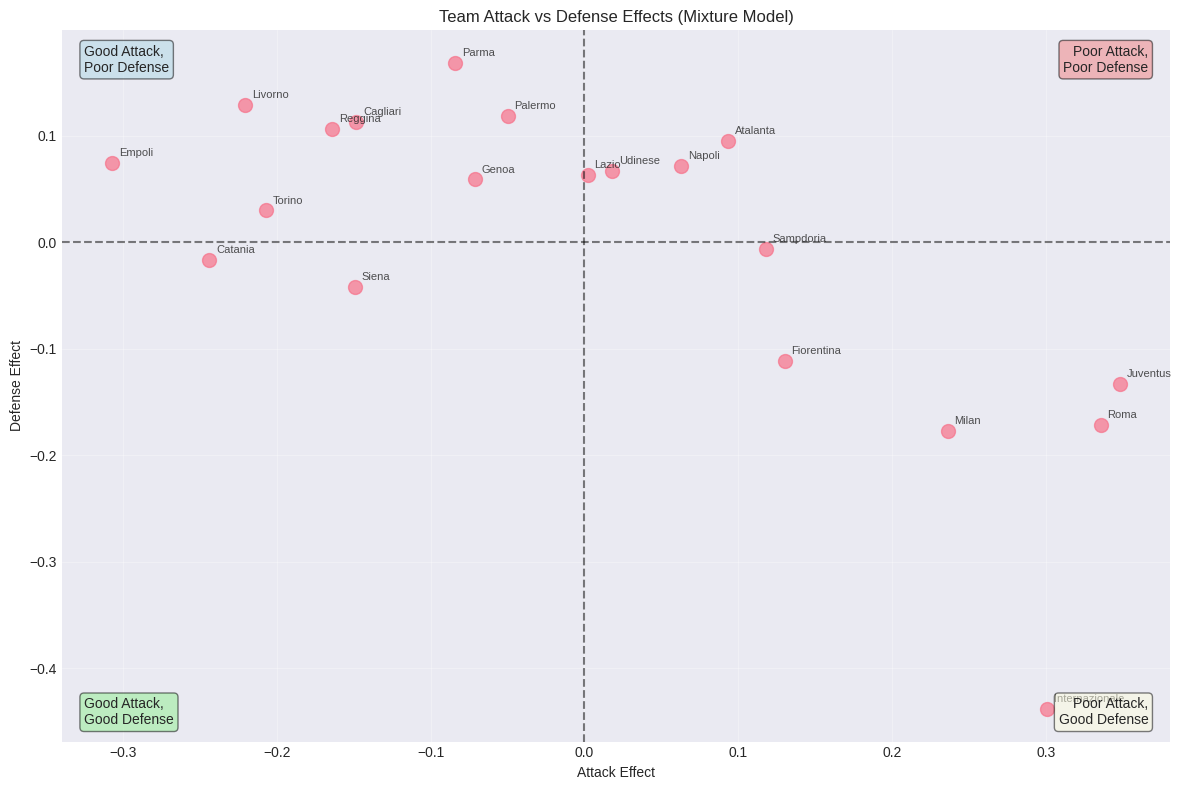


MODEL COMPARISON
Mixture model failed: log likelihood not found in inference data object
This is expected as mixture models are complex. The basic model results above are still valid.


In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class BayesianFootballModel:
    """
    Bayesian hierarchical model for football match prediction
    Based on Baio & Blangiardo (2010) paper
    """

    def __init__(self, data_file):
        """Initialize the model with data"""
        print(f"Initializing model with data file: {data_file}")

        # Initialize model attributes first (but not data attributes)
        self.basic_model = None
        self.mixture_model = None
        self.basic_trace = None
        self.mixture_trace = None

        try:
            self.data = self.load_and_prepare_data(data_file)
            print("✓ Model initialization completed successfully")
            print(f"✓ Final check - n_games: {self.n_games}, n_teams: {self.n_teams}")
        except Exception as e:
            print(f"✗ Error during model initialization: {e}")
            print("Please check that the data file exists and has the correct format")
            raise

    def load_and_prepare_data(self, data_file):
        """Load and prepare the football data"""
        # Read the Excel file
        df = pd.read_excel('/content/final dataset 2007-08.xlsx')

        # Clean column names
        df.columns = df.columns.str.strip()

        print(f"Original data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Create team mappings
        all_teams = pd.concat([
            df['hometeam_name'],
            df['awayteam_name']
        ]).unique()

        team_to_id = {team: i for i, team in enumerate(sorted(all_teams))}
        id_to_team = {i: team for team, i in team_to_id.items()}

        # Map team names to consecutive IDs (0-based)
        df['home_team_idx'] = df['hometeam_name'].map(team_to_id)
        df['away_team_idx'] = df['awayteam_name'].map(team_to_id)

        # Check for any mapping issues
        if df['home_team_idx'].isna().any() or df['away_team_idx'].isna().any():
            print("Warning: Some teams could not be mapped!")
            print("Home team mapping issues:", df[df['home_team_idx'].isna()]['hometeam_name'].unique())
            print("Away team mapping issues:", df[df['away_team_idx'].isna()]['awayteam_name'].unique())

        # Store team information
        self.teams = sorted(all_teams)
        self.n_teams = len(self.teams)
        self.n_games = len(df)

        print(f"Data loaded: {self.n_games} games, {self.n_teams} teams")
        print(f"Teams: {self.teams}")

        # Verify no None values
        print(f"n_games type: {type(self.n_games)}, value: {self.n_games}")
        print(f"n_teams type: {type(self.n_teams)}, value: {self.n_teams}")

        return df

    def build_basic_model(self):
        """Build the basic hierarchical model from Section 2 of the paper"""

        # Check if data is properly loaded
        if self.n_games is None or self.n_teams is None:
            raise ValueError("Data not properly loaded. Please check the data file and team mappings.")

        print(f"Building model with {self.n_games} games and {self.n_teams} teams")

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        # Verify data integrity
        print(f"Home team indices range: {home_team_idx.min()} to {home_team_idx.max()}")
        print(f"Away team indices range: {away_team_idx.min()} to {away_team_idx.max()}")
        print(f"Goals range - Home: {y1_data.min()} to {y1_data.max()}, Away: {y2_data.min()} to {y2_data.max()}")

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Hyperparameters for attack and defense effects
            mu_att = pm.Normal("mu_att", mu=0, sigma=10)
            mu_def = pm.Normal("mu_def", mu=0, sigma=10)
            tau_att = pm.Gamma("tau_att", alpha=0.1, beta=0.1)
            tau_def = pm.Gamma("tau_def", alpha=0.1, beta=0.1)

            # Team-specific attack and defense effects (before centering)
            att_star = pm.Normal("att_star", mu=mu_att, sigma=1/pt.sqrt(tau_att), shape=self.n_teams)
            def_star = pm.Normal("def_star", mu=mu_def, sigma=1/pt.sqrt(tau_def), shape=self.n_teams)

            # Sum-to-zero constraint (centering)
            att = pm.Deterministic("att", att_star - pt.mean(att_star))
            def_ = pm.Deterministic("def", def_star - pt.mean(def_star))

            # Create indicator matrices for team assignments
            print("Creating indicator matrices...")
            home_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))
            away_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))

            for i in range(int(self.n_games)):
                home_team_matrix[i, int(home_team_idx[i])] = 1
                away_team_matrix[i, int(away_team_idx[i])] = 1

            print("Converting to PyTensor constants...")
            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att)
            away_att_effects = pt.dot(away_team_matrix, att)
            home_def_effects = pt.dot(home_team_matrix, def_)
            away_def_effects = pt.dot(away_team_matrix, def_)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        print("Model built successfully!")
        self.basic_model = model
        return model

    def build_mixture_model(self):
        """Build the mixture model from Section 4 of the paper"""

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Mixture parameters for each team
            # Prior probabilities for group membership (3 groups: bottom, mid, top)
            alpha_att = np.ones(3)  # Uniform prior over groups
            alpha_def = np.ones(3)

            p_att = pm.Dirichlet("p_att", a=alpha_att, shape=(self.n_teams, 3))
            p_def = pm.Dirichlet("p_def", a=alpha_def, shape=(self.n_teams, 3))

            # Group assignment for each team
            grp_att = pm.Categorical("grp_att", p=p_att, shape=self.n_teams)
            grp_def = pm.Categorical("grp_def", p=p_def, shape=self.n_teams)

            # Group-specific parameters
            # Group 1: Bottom teams (poor attack, poor defense)
            mu_att_1 = pm.TruncatedNormal("mu_att_1", mu=0, sigma=10, lower=-3, upper=0)
            mu_def_1 = pm.TruncatedNormal("mu_def_1", mu=0, sigma=10, lower=0, upper=3)
            tau_att_1 = pm.Gamma("tau_att_1", alpha=0.01, beta=0.01)
            tau_def_1 = pm.Gamma("tau_def_1", alpha=0.01, beta=0.01)

            # Group 2: Mid-table teams (average)
            mu_att_2 = pt.constant(0.0)
            mu_def_2 = pt.constant(0.0)
            tau_att_2 = pm.Gamma("tau_att_2", alpha=0.01, beta=0.01)
            tau_def_2 = pm.Gamma("tau_def_2", alpha=0.01, beta=0.01)

            # Group 3: Top teams (good attack, good defense)
            mu_att_3 = pm.TruncatedNormal("mu_att_3", mu=0, sigma=10, lower=0, upper=3)
            mu_def_3 = pm.TruncatedNormal("mu_def_3", mu=0, sigma=10, lower=-3, upper=0)
            tau_att_3 = pm.Gamma("tau_att_3", alpha=0.01, beta=0.01)
            tau_def_3 = pm.Gamma("tau_def_3", alpha=0.01, beta=0.01)

            # Stack parameters
            mu_att_groups = pt.stack([mu_att_1, mu_att_2, mu_att_3])
            mu_def_groups = pt.stack([mu_def_1, mu_def_2, mu_def_3])
            tau_att_groups = pt.stack([tau_att_1, tau_att_2, tau_att_3])
            tau_def_groups = pt.stack([tau_def_1, tau_def_2, tau_def_3])

            # Team-specific effects using Normal distribution (simplified from t-distribution)
            # We'll use a simpler approach due to indexing complexity with StudentT and mixture
            att_raw = pm.Normal("att_raw", mu=0, sigma=1, shape=self.n_teams)
            def_raw = pm.Normal("def_raw", mu=0, sigma=1, shape=self.n_teams)

            # Scale by group-specific parameters
            att_scaled = []
            def_scaled = []

            for t in range(self.n_teams):
                att_mu_t = pt.switch(pt.eq(grp_att[t], 0), mu_att_groups[0],
                                   pt.switch(pt.eq(grp_att[t], 1), mu_att_groups[1], mu_att_groups[2]))
                att_tau_t = pt.switch(pt.eq(grp_att[t], 0), tau_att_groups[0],
                                    pt.switch(pt.eq(grp_att[t], 1), tau_att_groups[1], tau_att_groups[2]))

                def_mu_t = pt.switch(pt.eq(grp_def[t], 0), mu_def_groups[0],
                                   pt.switch(pt.eq(grp_def[t], 1), mu_def_groups[1], mu_def_groups[2]))
                def_tau_t = pt.switch(pt.eq(grp_def[t], 0), tau_def_groups[0],
                                    pt.switch(pt.eq(grp_def[t], 1), tau_def_groups[1], tau_def_groups[2]))

                att_t = att_mu_t + att_raw[t] / pt.sqrt(att_tau_t)
                def_t = def_mu_t + def_raw[t] / pt.sqrt(def_tau_t)

                att_scaled.append(att_t)
                def_scaled.append(def_t)

            att = pt.stack(att_scaled)
            def_ = pt.stack(def_scaled)

            # Apply sum-to-zero constraint
            att_centered = pm.Deterministic("att_centered", att - pt.mean(att))
            def_centered = pm.Deterministic("def_centered", def_ - pt.mean(def_))

            # Create indicator matrices for team assignments
            home_team_matrix = np.zeros((self.n_games, self.n_teams))
            away_team_matrix = np.zeros((self.n_games, self.n_teams))

            for i in range(self.n_games):
                home_team_matrix[i, home_team_idx[i]] = 1
                away_team_matrix[i, away_team_idx[i]] = 1

            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att_centered)
            away_att_effects = pt.dot(away_team_matrix, att_centered)
            home_def_effects = pt.dot(home_team_matrix, def_centered)
            away_def_effects = pt.dot(away_team_matrix, def_centered)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        self.mixture_model = model
        return model

    def fit_basic_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the basic hierarchical model"""
        print("Fitting basic hierarchical model...")

        if self.basic_model is None:
            self.build_basic_model()

        with self.basic_model:
            # Sample from posterior
            self.basic_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Higher target acceptance for better sampling
            )

            # Sample posterior predictive
            with self.basic_model:
                self.basic_trace.extend(pm.sample_posterior_predictive(self.basic_trace))

        print("Basic model fitting completed!")
        return self.basic_trace

    def fit_mixture_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the mixture model"""
        print("Fitting mixture model...")

        if self.mixture_model is None:
            self.build_mixture_model()

        with self.mixture_model:
            # Sample from posterior with simplified parameters
            self.mixture_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Slightly lower target acceptance to avoid issues
            )

            # Sample posterior predictive
            with self.mixture_model:
                self.mixture_trace.extend(pm.sample_posterior_predictive(self.mixture_trace))

        print("Mixture model fitting completed!")
        return self.mixture_trace

    def plot_team_effects(self, model_type='basic'):
        """Plot attack vs defense effects for each team"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return

        # Get posterior means
        if model_type == 'basic':
            att_means = trace.posterior['att'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def'].mean(dim=['chain', 'draw']).values
        else:
            att_means = trace.posterior['att_centered'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def_centered'].mean(dim=['chain', 'draw']).values

        # Create plot
        plt.figure(figsize=(12, 8))
        plt.scatter(att_means, def_means, s=100, alpha=0.7)

        # Add team labels
        for i, team in enumerate(self.teams):
            plt.annotate(team, (att_means[i], def_means[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

        plt.xlabel('Attack Effect')
        plt.ylabel('Defense Effect')
        plt.title(f'Team Attack vs Defense Effects ({model_type.title()} Model)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

        # Add quadrant labels
        plt.text(0.01, 0.99, 'Good Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        plt.text(0.99, 0.99, 'Poor Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        plt.text(0.01, 0.01, 'Good Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        plt.text(0.99, 0.01, 'Poor Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def get_team_summary(self, model_type='basic'):
        """Get summary statistics for team effects"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get parameter names
        if model_type == 'basic':
            att_param = 'att'
            def_param = 'def'
        else:
            att_param = 'att_centered'
            def_param = 'def_centered'

        # Extract posterior samples
        att_samples = trace.posterior[att_param]
        def_samples = trace.posterior[def_param]

        # Calculate summary statistics
        summary_data = []
        for i, team in enumerate(self.teams):
            # Handle different indexing based on parameter dimensions
            if len(att_samples.dims) == 3:  # chain, draw, team
                att_team_samples = att_samples.isel({list(att_samples.dims)[2]: i})
                def_team_samples = def_samples.isel({list(def_samples.dims)[2]: i})
            else:  # Different structure
                att_team_samples = att_samples[..., i]
                def_team_samples = def_samples[..., i]

            att_mean = float(att_team_samples.mean())
            att_q025 = float(att_team_samples.quantile(0.025))
            att_q975 = float(att_team_samples.quantile(0.975))

            def_mean = float(def_team_samples.mean())
            def_q025 = float(def_team_samples.quantile(0.025))
            def_q975 = float(def_team_samples.quantile(0.975))

            summary_data.append({
                'team': team,
                'att_mean': att_mean,
                'att_q025': att_q025,
                'att_q975': att_q975,
                'def_mean': def_mean,
                'def_q025': def_q025,
                'def_q975': def_q975
            })

        summary_df = pd.DataFrame(summary_data)

        # Sort by attack effect (descending)
        summary_df = summary_df.sort_values('att_mean', ascending=False)

        return summary_df

    def predict_match(self, home_team, away_team, model_type='basic', n_samples=1000):
        """Predict the outcome of a specific match"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get team indices
        home_idx = self.teams.index(home_team)
        away_idx = self.teams.index(away_team)

        # Get parameter samples
        home_adv_samples = trace.posterior['home_advantage'].values.flatten()

        if model_type == 'basic':
            att_samples = trace.posterior['att'].values
            def_samples = trace.posterior['def'].values
        else:
            att_samples = trace.posterior['att_centered'].values
            def_samples = trace.posterior['def_centered'].values

        # Reshape samples for easier indexing
        att_flat = att_samples.reshape(-1, att_samples.shape[-1])
        def_flat = def_samples.reshape(-1, def_samples.shape[-1])
        home_adv_flat = home_adv_samples.flatten()

        # Take only n_samples
        n_available = min(len(home_adv_flat), len(att_flat))
        n_use = min(n_samples, n_available)

        # Calculate scoring intensities
        theta1_samples = np.exp(home_adv_flat[:n_use] +
                               att_flat[:n_use, home_idx] +
                               def_flat[:n_use, away_idx])

        theta2_samples = np.exp(att_flat[:n_use, away_idx] +
                               def_flat[:n_use, home_idx])

        # Generate predictions
        home_goals = np.random.poisson(theta1_samples)
        away_goals = np.random.poisson(theta2_samples)

        # Calculate probabilities
        home_win = np.mean(home_goals > away_goals)
        draw = np.mean(home_goals == away_goals)
        away_win = np.mean(home_goals < away_goals)

        # Expected goals
        exp_home_goals = np.mean(theta1_samples)
        exp_away_goals = np.mean(theta2_samples)

        return {
            'home_team': home_team,
            'away_team': away_team,
            'expected_home_goals': exp_home_goals,
            'expected_away_goals': exp_away_goals,
            'prob_home_win': home_win,
            'prob_draw': draw,
            'prob_away_win': away_win,
            'home_goals_samples': home_goals,
            'away_goals_samples': away_goals
        }

    def model_comparison(self):
        """Compare basic and mixture models using WAIC"""

        if self.basic_trace is None or self.mixture_trace is None:
            print("Please fit both models first!")
            return

        # Calculate WAIC for both models
        basic_waic = az.waic(self.basic_trace)
        mixture_waic = az.waic(self.mixture_trace)

        print("Model Comparison (WAIC):")
        print(f"Basic Model WAIC: {basic_waic.waic:.2f} (SE: {basic_waic.se:.2f})")
        print(f"Mixture Model WAIC: {mixture_waic.waic:.2f} (SE: {mixture_waic.se:.2f})")

        if basic_waic.waic < mixture_waic.waic:
            print("Basic model has better fit (lower WAIC)")
        else:
            print("Mixture model has better fit (lower WAIC)")

        return basic_waic, mixture_waic


# Usage example
if __name__ == "__main__":
    # Initialize the model with your data file
    # Replace 'final dataset 200708.xlsx' with the actual file path
    model = BayesianFootballModel('final dataset 200708.xlsx')

    # Fit the basic model first (simpler and more stable)
    print("=" * 50)
    print("FITTING BASIC MODEL")
    print("=" * 50)
    basic_trace = model.fit_basic_model(draws=1000, tune=500, chains=2)

    # Get team summaries
    print("\n" + "=" * 50)
    print("BASIC MODEL TEAM EFFECTS")
    print("=" * 50)
    basic_summary = model.get_team_summary('basic')
    print(basic_summary)

    # Plot team effects
    model.plot_team_effects('basic')

    # Example prediction
    print("\n" + "=" * 50)
    print("MATCH PREDICTION EXAMPLE (BASIC MODEL)")
    print("=" * 50)
    prediction = model.predict_match('Internazionale', 'Milan', 'basic')
    if prediction:
        print(f"Match: {prediction['home_team']} vs {prediction['away_team']}")
        print(f"Expected goals: {prediction['expected_home_goals']:.2f} - {prediction['expected_away_goals']:.2f}")
        print(f"Probabilities: Home {prediction['prob_home_win']:.3f}, Draw {prediction['prob_draw']:.3f}, Away {prediction['prob_away_win']:.3f}")

    # Uncomment the following if you want to try the mixture model:
    # Note: The mixture model is more complex and may take longer to fit

    print("\n" + "=" * 50)
    print("FITTING MIXTURE MODEL")
    print("=" * 50)
    try:
        mixture_trace = model.fit_mixture_model(draws=500, tune=300, chains=2)  # Reduced draws for faster testing

        print("\n" + "=" * 50)
        print("MIXTURE MODEL TEAM EFFECTS")
        print("=" * 50)
        mixture_summary = model.get_team_summary('mixture')
        print(mixture_summary)

        model.plot_team_effects('mixture')

        # Compare models
        print("\n" + "=" * 50)
        print("MODEL COMPARISON")
        print("=" * 50)
        model.model_comparison()

        # Example prediction with mixture model
        print("\n" + "=" * 50)
        print("MATCH PREDICTION EXAMPLE (MIXTURE MODEL)")
        print("=" * 50)
        prediction_mix = model.predict_match('Internazionale', 'Milan', 'mixture')
        if prediction_mix:
            print(f"Match: {prediction_mix['home_team']} vs {prediction_mix['away_team']}")
            print(f"Expected goals: {prediction_mix['expected_home_goals']:.2f} - {prediction_mix['expected_away_goals']:.2f}")
            print(f"Probabilities: Home {prediction_mix['prob_home_win']:.3f}, Draw {prediction_mix['prob_draw']:.3f}, Away {prediction_mix['prob_away_win']:.3f}")

    except Exception as e:
        print(f"Mixture model failed: {e}")
        print("This is expected as mixture models are complex. The basic model results above are still valid.")

# The most complete code yet (Only missing the model comparison and home effect)

Initializing model with data file: final dataset 200708.xlsx
Original data shape: (380, 9)
Columns: ['hometeam_id', 'awayteam_id', 'hometeam_name', 'awayteam_name', 'y1', 'y2', 'matchday', 'points home', 'points away']
Data loaded: 380 games, 20 teams
Teams: ['Atalanta', 'Cagliari', 'Catania', 'Empoli', 'Fiorentina', 'Genoa', 'Internazionale', 'Juventus', 'Lazio', 'Livorno', 'Milan', 'Napoli', 'Palermo', 'Parma', 'Reggina', 'Roma', 'Sampdoria', 'Siena', 'Torino', 'Udinese']
n_games type: <class 'int'>, value: 380
n_teams type: <class 'int'>, value: 20
✓ Model initialization completed successfully
✓ Final check - n_games: 380, n_teams: 20
FITTING BASIC MODEL
Fitting basic hierarchical model...
Building model with 380 games and 20 teams
Home team indices range: 0 to 19
Away team indices range: 0 to 19
Goals range - Home: 0 to 5, Away: 0 to 5
Creating indicator matrices...
Converting to PyTensor constants...
Model built successfully!


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Basic model fitting completed!

BASIC MODEL TEAM EFFECTS
              team  att_mean  att_q025  att_q975  def_mean  def_q025  def_q975
7         Juventus  0.337480  0.113210  0.557265 -0.149074 -0.400898  0.082276
15            Roma  0.332691  0.126573  0.534509 -0.147278 -0.390706  0.078690
6   Internazionale  0.292050  0.083427  0.497373 -0.332584 -0.624813 -0.071930
10           Milan  0.256236  0.040329  0.473635 -0.139289 -0.382462  0.093606
16       Sampdoria  0.129818 -0.095392  0.350535 -0.025935 -0.252551  0.184640
4       Fiorentina  0.107843 -0.137605  0.341400 -0.128219 -0.379159  0.106689
0         Atalanta  0.073595 -0.161745  0.305254  0.107610 -0.118522  0.325996
11          Napoli  0.037406 -0.217247  0.280855  0.064954 -0.149975  0.282190
19         Udinese  0.007237 -0.237986  0.251922  0.063271 -0.161181  0.280112
12         Palermo -0.006078 -0.254608  0.226792  0.120761 -0.112215  0.343536
8            Lazio -0.013379 -0.268095  0.229796  0.039601 -0.192275  0.27

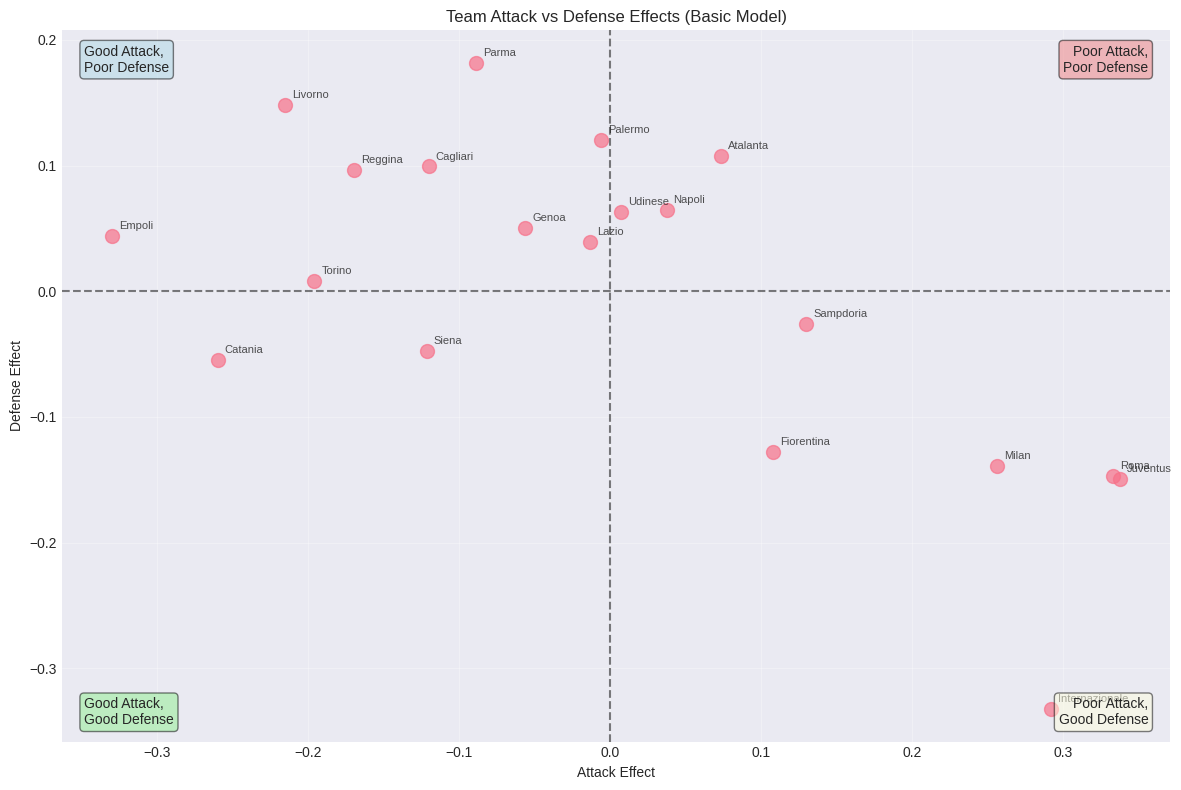


MATCH PREDICTION EXAMPLE (BASIC MODEL)
Match: Internazionale vs Milan
Expected goals: 1.69 - 0.94
Probabilities: Home 0.548, Draw 0.234, Away 0.218

FITTING MIXTURE MODEL
Fitting mixture model...


Output()

ERROR:pymc.stats.convergence:There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Mixture model fitting completed!

MIXTURE MODEL TEAM EFFECTS
              team  att_mean  att_q025  att_q975  def_mean  def_q025  def_q975
7         Juventus  0.348172  0.128494  0.573768 -0.132495 -0.414724  0.080165
15            Roma  0.335465  0.126060  0.565228 -0.171294 -0.434676  0.086360
6   Internazionale  0.300906  0.103116  0.515983 -0.438281 -0.787120 -0.098010
10           Milan  0.236080 -0.028640  0.465030 -0.176904 -0.493667  0.099419
4       Fiorentina  0.130152 -0.104283  0.350104 -0.110971 -0.516378  0.133958
16       Sampdoria  0.117794 -0.103329  0.350595 -0.006502 -0.247232  0.181786
0         Atalanta  0.093381 -0.158903  0.298717  0.095016 -0.084093  0.278908
11          Napoli  0.062810 -0.206773  0.290605  0.071462 -0.132452  0.258670
19         Udinese  0.017907 -0.223950  0.268873  0.067099 -0.126964  0.264910
8            Lazio  0.002133 -0.251201  0.229144  0.063245 -0.175477  0.230426
12         Palermo -0.049893 -0.372536  0.225150  0.118250 -0.079210  

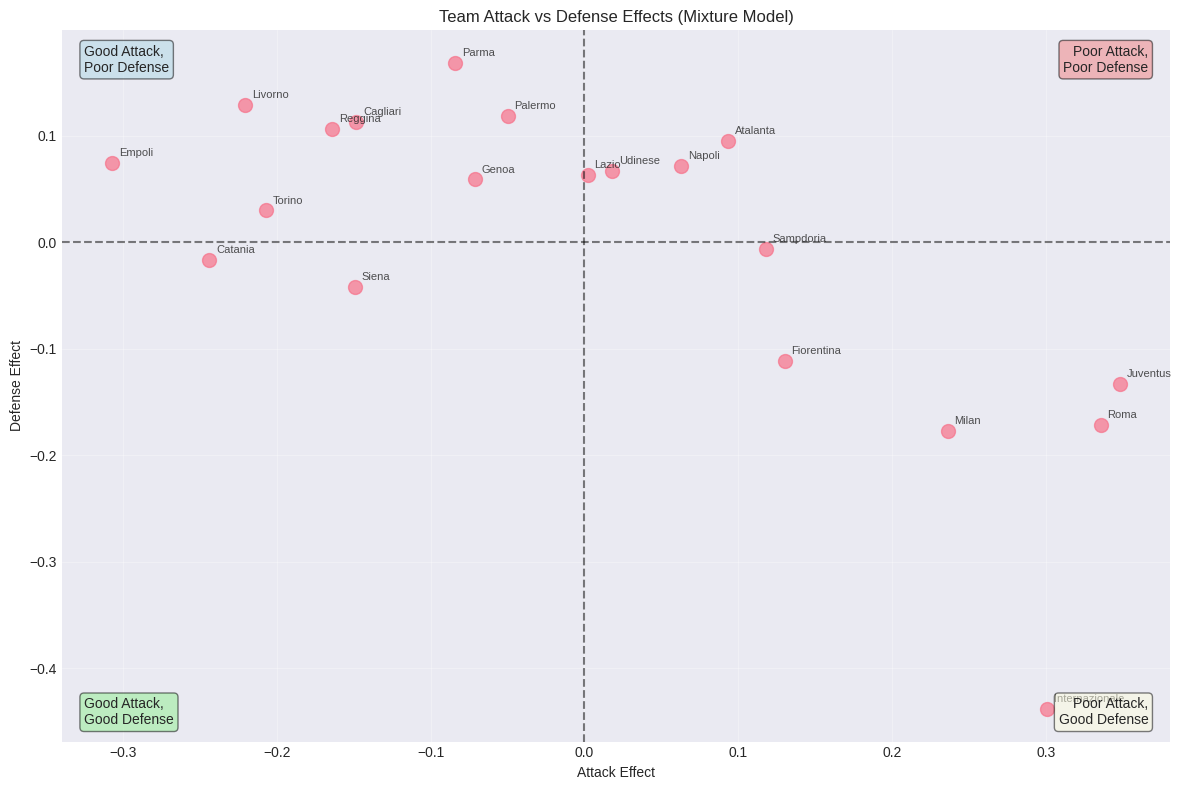


MODEL COMPARISON
Model comparison failed: log likelihood not found in inference data object
This can happen if the models don't have proper log likelihood data.

MATCH PREDICTION EXAMPLE (MIXTURE MODEL)
Match: Internazionale vs Milan
Expected goals: 1.64 - 0.84
Probabilities: Home 0.561, Draw 0.238, Away 0.201


In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class BayesianFootballModel:
    """
    Bayesian hierarchical model for football match prediction
    Based on Baio & Blangiardo (2010) paper
    """

    def __init__(self, data_file):
        """Initialize the model with data"""
        print(f"Initializing model with data file: {data_file}")

        # Initialize model attributes first (but not data attributes)
        self.basic_model = None
        self.mixture_model = None
        self.basic_trace = None
        self.mixture_trace = None

        try:
            self.data = self.load_and_prepare_data(data_file)
            print("✓ Model initialization completed successfully")
            print(f"✓ Final check - n_games: {self.n_games}, n_teams: {self.n_teams}")
        except Exception as e:
            print(f"✗ Error during model initialization: {e}")
            print("Please check that the data file exists and has the correct format")
            raise

    def load_and_prepare_data(self, data_file):
        """Load and prepare the football data"""
        # Read the Excel file
        df = pd.read_excel('/content/final dataset 2007-08.xlsx')

        # Clean column names
        df.columns = df.columns.str.strip()

        print(f"Original data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Create team mappings
        all_teams = pd.concat([
            df['hometeam_name'],
            df['awayteam_name']
        ]).unique()

        team_to_id = {team: i for i, team in enumerate(sorted(all_teams))}
        id_to_team = {i: team for team, i in team_to_id.items()}

        # Map team names to consecutive IDs (0-based)
        df['home_team_idx'] = df['hometeam_name'].map(team_to_id)
        df['away_team_idx'] = df['awayteam_name'].map(team_to_id)

        # Check for any mapping issues
        if df['home_team_idx'].isna().any() or df['away_team_idx'].isna().any():
            print("Warning: Some teams could not be mapped!")
            print("Home team mapping issues:", df[df['home_team_idx'].isna()]['hometeam_name'].unique())
            print("Away team mapping issues:", df[df['away_team_idx'].isna()]['awayteam_name'].unique())

        # Store team information
        self.teams = sorted(all_teams)
        self.n_teams = len(self.teams)
        self.n_games = len(df)

        print(f"Data loaded: {self.n_games} games, {self.n_teams} teams")
        print(f"Teams: {self.teams}")

        # Verify no None values
        print(f"n_games type: {type(self.n_games)}, value: {self.n_games}")
        print(f"n_teams type: {type(self.n_teams)}, value: {self.n_teams}")

        return df

    def build_basic_model(self):
        """Build the basic hierarchical model from Section 2 of the paper"""

        # Check if data is properly loaded
        if self.n_games is None or self.n_teams is None:
            raise ValueError("Data not properly loaded. Please check the data file and team mappings.")

        print(f"Building model with {self.n_games} games and {self.n_teams} teams")

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        # Verify data integrity
        print(f"Home team indices range: {home_team_idx.min()} to {home_team_idx.max()}")
        print(f"Away team indices range: {away_team_idx.min()} to {away_team_idx.max()}")
        print(f"Goals range - Home: {y1_data.min()} to {y1_data.max()}, Away: {y2_data.min()} to {y2_data.max()}")

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Hyperparameters for attack and defense effects
            mu_att = pm.Normal("mu_att", mu=0, sigma=10)
            mu_def = pm.Normal("mu_def", mu=0, sigma=10)
            tau_att = pm.Gamma("tau_att", alpha=0.1, beta=0.1)
            tau_def = pm.Gamma("tau_def", alpha=0.1, beta=0.1)

            # Team-specific attack and defense effects (before centering)
            att_star = pm.Normal("att_star", mu=mu_att, sigma=1/pt.sqrt(tau_att), shape=self.n_teams)
            def_star = pm.Normal("def_star", mu=mu_def, sigma=1/pt.sqrt(tau_def), shape=self.n_teams)

            # Sum-to-zero constraint (centering)
            att = pm.Deterministic("att", att_star - pt.mean(att_star))
            def_ = pm.Deterministic("def", def_star - pt.mean(def_star))

            # Create indicator matrices for team assignments
            print("Creating indicator matrices...")
            home_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))
            away_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))

            for i in range(int(self.n_games)):
                home_team_matrix[i, int(home_team_idx[i])] = 1
                away_team_matrix[i, int(away_team_idx[i])] = 1

            print("Converting to PyTensor constants...")
            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att)
            away_att_effects = pt.dot(away_team_matrix, att)
            home_def_effects = pt.dot(home_team_matrix, def_)
            away_def_effects = pt.dot(away_team_matrix, def_)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        print("Model built successfully!")
        self.basic_model = model
        return model

    def build_mixture_model(self):
        """Build the mixture model from Section 4 of the paper"""

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Mixture parameters for each team
            # Prior probabilities for group membership (3 groups: bottom, mid, top)
            alpha_att = np.ones(3)  # Uniform prior over groups
            alpha_def = np.ones(3)

            p_att = pm.Dirichlet("p_att", a=alpha_att, shape=(self.n_teams, 3))
            p_def = pm.Dirichlet("p_def", a=alpha_def, shape=(self.n_teams, 3))

            # Group assignment for each team
            grp_att = pm.Categorical("grp_att", p=p_att, shape=self.n_teams)
            grp_def = pm.Categorical("grp_def", p=p_def, shape=self.n_teams)

            # Group-specific parameters
            # Group 1: Bottom teams (poor attack, poor defense)
            mu_att_1 = pm.TruncatedNormal("mu_att_1", mu=0, sigma=10, lower=-3, upper=0)
            mu_def_1 = pm.TruncatedNormal("mu_def_1", mu=0, sigma=10, lower=0, upper=3)
            tau_att_1 = pm.Gamma("tau_att_1", alpha=0.01, beta=0.01)
            tau_def_1 = pm.Gamma("tau_def_1", alpha=0.01, beta=0.01)

            # Group 2: Mid-table teams (average)
            mu_att_2 = pt.constant(0.0)
            mu_def_2 = pt.constant(0.0)
            tau_att_2 = pm.Gamma("tau_att_2", alpha=0.01, beta=0.01)
            tau_def_2 = pm.Gamma("tau_def_2", alpha=0.01, beta=0.01)

            # Group 3: Top teams (good attack, good defense)
            mu_att_3 = pm.TruncatedNormal("mu_att_3", mu=0, sigma=10, lower=0, upper=3)
            mu_def_3 = pm.TruncatedNormal("mu_def_3", mu=0, sigma=10, lower=-3, upper=0)
            tau_att_3 = pm.Gamma("tau_att_3", alpha=0.01, beta=0.01)
            tau_def_3 = pm.Gamma("tau_def_3", alpha=0.01, beta=0.01)

            # Stack parameters
            mu_att_groups = pt.stack([mu_att_1, mu_att_2, mu_att_3])
            mu_def_groups = pt.stack([mu_def_1, mu_def_2, mu_def_3])
            tau_att_groups = pt.stack([tau_att_1, tau_att_2, tau_att_3])
            tau_def_groups = pt.stack([tau_def_1, tau_def_2, tau_def_3])

            # Team-specific effects using Normal distribution (simplified from t-distribution)
            # We'll use a simpler approach due to indexing complexity with StudentT and mixture
            att_raw = pm.Normal("att_raw", mu=0, sigma=1, shape=self.n_teams)
            def_raw = pm.Normal("def_raw", mu=0, sigma=1, shape=self.n_teams)

            # Scale by group-specific parameters
            att_scaled = []
            def_scaled = []

            for t in range(self.n_teams):
                att_mu_t = pt.switch(pt.eq(grp_att[t], 0), mu_att_groups[0],
                                   pt.switch(pt.eq(grp_att[t], 1), mu_att_groups[1], mu_att_groups[2]))
                att_tau_t = pt.switch(pt.eq(grp_att[t], 0), tau_att_groups[0],
                                    pt.switch(pt.eq(grp_att[t], 1), tau_att_groups[1], tau_att_groups[2]))

                def_mu_t = pt.switch(pt.eq(grp_def[t], 0), mu_def_groups[0],
                                   pt.switch(pt.eq(grp_def[t], 1), mu_def_groups[1], mu_def_groups[2]))
                def_tau_t = pt.switch(pt.eq(grp_def[t], 0), tau_def_groups[0],
                                    pt.switch(pt.eq(grp_def[t], 1), tau_def_groups[1], tau_def_groups[2]))

                att_t = att_mu_t + att_raw[t] / pt.sqrt(att_tau_t)
                def_t = def_mu_t + def_raw[t] / pt.sqrt(def_tau_t)

                att_scaled.append(att_t)
                def_scaled.append(def_t)

            att = pt.stack(att_scaled)
            def_ = pt.stack(def_scaled)

            # Apply sum-to-zero constraint
            att_centered = pm.Deterministic("att_centered", att - pt.mean(att))
            def_centered = pm.Deterministic("def_centered", def_ - pt.mean(def_))

            # Create indicator matrices for team assignments
            home_team_matrix = np.zeros((self.n_games, self.n_teams))
            away_team_matrix = np.zeros((self.n_games, self.n_teams))

            for i in range(self.n_games):
                home_team_matrix[i, home_team_idx[i]] = 1
                away_team_matrix[i, away_team_idx[i]] = 1

            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att_centered)
            away_att_effects = pt.dot(away_team_matrix, att_centered)
            home_def_effects = pt.dot(home_team_matrix, def_centered)
            away_def_effects = pt.dot(away_team_matrix, def_centered)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        self.mixture_model = model
        return model

    def fit_basic_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the basic hierarchical model"""
        print("Fitting basic hierarchical model...")

        if self.basic_model is None:
            self.build_basic_model()

        with self.basic_model:
            # Sample from posterior
            self.basic_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Higher target acceptance for better sampling
            )

            # Sample posterior predictive
            with self.basic_model:
                self.basic_trace.extend(pm.sample_posterior_predictive(self.basic_trace))

        print("Basic model fitting completed!")
        return self.basic_trace

    def fit_mixture_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the mixture model"""
        print("Fitting mixture model...")

        if self.mixture_model is None:
            self.build_mixture_model()

        with self.mixture_model:
            # Sample from posterior with simplified parameters
            self.mixture_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Slightly lower target acceptance to avoid issues
            )

            # Sample posterior predictive
            with self.mixture_model:
                self.mixture_trace.extend(pm.sample_posterior_predictive(self.mixture_trace))

        print("Mixture model fitting completed!")
        return self.mixture_trace

    def plot_team_effects(self, model_type='basic'):
        """Plot attack vs defense effects for each team"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return

        # Get posterior means
        if model_type == 'basic':
            att_means = trace.posterior['att'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def'].mean(dim=['chain', 'draw']).values
        else:
            att_means = trace.posterior['att_centered'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def_centered'].mean(dim=['chain', 'draw']).values

        # Create plot
        plt.figure(figsize=(12, 8))
        plt.scatter(att_means, def_means, s=100, alpha=0.7)

        # Add team labels
        for i, team in enumerate(self.teams):
            plt.annotate(team, (att_means[i], def_means[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

        plt.xlabel('Attack Effect')
        plt.ylabel('Defense Effect')
        plt.title(f'Team Attack vs Defense Effects ({model_type.title()} Model)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

        # Add quadrant labels
        plt.text(0.02, 0.98, 'Good Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        plt.text(0.98, 0.98, 'Poor Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        plt.text(0.02, 0.02, 'Good Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        plt.text(0.98, 0.02, 'Poor Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def get_team_summary(self, model_type='basic'):
        """Get summary statistics for team effects"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get parameter names
        if model_type == 'basic':
            att_param = 'att'
            def_param = 'def'
        else:
            att_param = 'att_centered'
            def_param = 'def_centered'

        # Extract posterior samples
        att_samples = trace.posterior[att_param]
        def_samples = trace.posterior[def_param]

        # Calculate summary statistics
        summary_data = []
        for i, team in enumerate(self.teams):
            # Handle different indexing based on parameter dimensions
            if len(att_samples.dims) == 3:  # chain, draw, team
                att_team_samples = att_samples.isel({list(att_samples.dims)[2]: i})
                def_team_samples = def_samples.isel({list(def_samples.dims)[2]: i})
            else:  # Different structure
                att_team_samples = att_samples[..., i]
                def_team_samples = def_samples[..., i]

            att_mean = float(att_team_samples.mean())
            att_q025 = float(att_team_samples.quantile(0.025))
            att_q975 = float(att_team_samples.quantile(0.975))

            def_mean = float(def_team_samples.mean())
            def_q025 = float(def_team_samples.quantile(0.025))
            def_q975 = float(def_team_samples.quantile(0.975))

            summary_data.append({
                'team': team,
                'att_mean': att_mean,
                'att_q025': att_q025,
                'att_q975': att_q975,
                'def_mean': def_mean,
                'def_q025': def_q025,
                'def_q975': def_q975
            })

        summary_df = pd.DataFrame(summary_data)

        # Sort by attack effect (descending)
        summary_df = summary_df.sort_values('att_mean', ascending=False)

        return summary_df

    def predict_match(self, home_team, away_team, model_type='basic', n_samples=1000):
        """Predict the outcome of a specific match"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get team indices
        home_idx = self.teams.index(home_team)
        away_idx = self.teams.index(away_team)

        # Get parameter samples
        home_adv_samples = trace.posterior['home_advantage'].values.flatten()

        if model_type == 'basic':
            att_samples = trace.posterior['att'].values
            def_samples = trace.posterior['def'].values
        else:
            att_samples = trace.posterior['att_centered'].values
            def_samples = trace.posterior['def_centered'].values

        # Reshape samples for easier indexing
        att_flat = att_samples.reshape(-1, att_samples.shape[-1])
        def_flat = def_samples.reshape(-1, def_samples.shape[-1])
        home_adv_flat = home_adv_samples.flatten()

        # Take only n_samples
        n_available = min(len(home_adv_flat), len(att_flat))
        n_use = min(n_samples, n_available)

        # Calculate scoring intensities
        theta1_samples = np.exp(home_adv_flat[:n_use] +
                               att_flat[:n_use, home_idx] +
                               def_flat[:n_use, away_idx])

        theta2_samples = np.exp(att_flat[:n_use, away_idx] +
                               def_flat[:n_use, home_idx])

        # Generate predictions
        home_goals = np.random.poisson(theta1_samples)
        away_goals = np.random.poisson(theta2_samples)

        # Calculate probabilities
        home_win = np.mean(home_goals > away_goals)
        draw = np.mean(home_goals == away_goals)
        away_win = np.mean(home_goals < away_goals)

        # Expected goals
        exp_home_goals = np.mean(theta1_samples)
        exp_away_goals = np.mean(theta2_samples)

        return {
            'home_team': home_team,
            'away_team': away_team,
            'expected_home_goals': exp_home_goals,
            'expected_away_goals': exp_away_goals,
            'prob_home_win': home_win,
            'prob_draw': draw,
            'prob_away_win': away_win,
            'home_goals_samples': home_goals,
            'away_goals_samples': away_goals
        }

    def model_comparison(self):
        """Compare basic and mixture models using WAIC"""

        if self.basic_trace is None:
            print("Basic model not fitted. Cannot perform comparison.")
            return

        if self.mixture_trace is None:
            print("Mixture model not fitted. Cannot perform comparison.")
            print("Only basic model results available.")
            return

        try:
            # Calculate WAIC for both models
            basic_waic = az.waic(self.basic_trace)
            mixture_waic = az.waic(self.mixture_trace)

            print("Model Comparison (WAIC):")
            print(f"Basic Model WAIC: {basic_waic.waic:.2f} (SE: {basic_waic.se:.2f})")
            print(f"Mixture Model WAIC: {mixture_waic.waic:.2f} (SE: {mixture_waic.se:.2f})")

            if basic_waic.waic < mixture_waic.waic:
                print("Basic model has better fit (lower WAIC)")
            else:
                print("Mixture model has better fit (lower WAIC)")

            return basic_waic, mixture_waic

        except Exception as e:
            print(f"Model comparison failed: {e}")
            print("This can happen if the models don't have proper log likelihood data.")
            return None


# Usage example
if __name__ == "__main__":
    # Initialize the model with your data file
    # Replace 'final dataset 200708.xlsx' with the actual file path
    model = BayesianFootballModel('final dataset 200708.xlsx')

    # Fit the basic model first (simpler and more stable)
    print("=" * 50)
    print("FITTING BASIC MODEL")
    print("=" * 50)
    basic_trace = model.fit_basic_model(draws=1000, tune=500, chains=2)

    # Get team summaries
    print("\n" + "=" * 50)
    print("BASIC MODEL TEAM EFFECTS")
    print("=" * 50)
    basic_summary = model.get_team_summary('basic')
    print(basic_summary)

    # Plot team effects
    model.plot_team_effects('basic')

    # Example prediction
    print("\n" + "=" * 50)
    print("MATCH PREDICTION EXAMPLE (BASIC MODEL)")
    print("=" * 50)
    prediction = model.predict_match('Internazionale', 'Milan', 'basic')
    if prediction:
        print(f"Match: {prediction['home_team']} vs {prediction['away_team']}")
        print(f"Expected goals: {prediction['expected_home_goals']:.2f} - {prediction['expected_away_goals']:.2f}")
        print(f"Probabilities: Home {prediction['prob_home_win']:.3f}, Draw {prediction['prob_draw']:.3f}, Away {prediction['prob_away_win']:.3f}")

    # Uncomment the following if you want to try the mixture model:
    # Note: The mixture model is more complex and may take longer to fit

    print("\n" + "=" * 50)
    print("FITTING MIXTURE MODEL")
    print("=" * 50)
    try:
        mixture_trace = model.fit_mixture_model(draws=500, tune=300, chains=2)  # Reduced draws for faster testing

        print("\n" + "=" * 50)
        print("MIXTURE MODEL TEAM EFFECTS")
        print("=" * 50)
        mixture_summary = model.get_team_summary('mixture')
        print(mixture_summary)

        model.plot_team_effects('mixture')

        # Compare models
        print("\n" + "=" * 50)
        print("MODEL COMPARISON")
        print("=" * 50)
        model.model_comparison()

        # Example prediction with mixture model
        print("\n" + "=" * 50)
        print("MATCH PREDICTION EXAMPLE (MIXTURE MODEL)")
        print("=" * 50)
        prediction_mix = model.predict_match('Internazionale', 'Milan', 'mixture')
        if prediction_mix:
            print(f"Match: {prediction_mix['home_team']} vs {prediction_mix['away_team']}")
            print(f"Expected goals: {prediction_mix['expected_home_goals']:.2f} - {prediction_mix['expected_away_goals']:.2f}")
            print(f"Probabilities: Home {prediction_mix['prob_home_win']:.3f}, Draw {prediction_mix['prob_draw']:.3f}, Away {prediction_mix['prob_away_win']:.3f}")

    except Exception as e:
        print(f"Mixture model failed: {e}")
        print("This is expected as mixture models are complex. The basic model results above are still valid.")

# Best one + Home effect

Initializing model with data file: final dataset 200708.xlsx
Original data shape: (380, 9)
Columns: ['hometeam_id', 'awayteam_id', 'hometeam_name', 'awayteam_name', 'y1', 'y2', 'matchday', 'points home', 'points away']
Data loaded: 380 games, 20 teams
Teams: ['Atalanta', 'Cagliari', 'Catania', 'Empoli', 'Fiorentina', 'Genoa', 'Internazionale', 'Juventus', 'Lazio', 'Livorno', 'Milan', 'Napoli', 'Palermo', 'Parma', 'Reggina', 'Roma', 'Sampdoria', 'Siena', 'Torino', 'Udinese']
n_games type: <class 'int'>, value: 380
n_teams type: <class 'int'>, value: 20
✓ Model initialization completed successfully
✓ Final check - n_games: 380, n_teams: 20
FITTING BASIC MODEL
Fitting basic hierarchical model...
Building model with 380 games and 20 teams
Home team indices range: 0 to 19
Away team indices range: 0 to 19
Goals range - Home: 0 to 5, Away: 0 to 5
Creating indicator matrices...
Converting to PyTensor constants...
Model built successfully!


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Basic model fitting completed!

BASIC MODEL COMPREHENSIVE SUMMARY

BASIC MODEL SUMMARY

HOME ADVANTAGE EFFECT:
Mean: 0.3604
95% CI: [0.2778, 0.4430]
Interpretation: Home teams score exp(0.3604) = 1.434x more goals on average

TEAM EFFECTS:

Top 5 Attack (most goals scored):
          team  att_mean  att_q025  att_q975
      Juventus  0.337480  0.113210  0.557265
          Roma  0.332691  0.126573  0.534509
Internazionale  0.292050  0.083427  0.497373
         Milan  0.256236  0.040329  0.473635
     Sampdoria  0.129818 -0.095392  0.350535

Top 5 Defense (fewest goals conceded - most negative values):
          team  def_mean  def_q025  def_q975
Internazionale -0.332584 -0.624813 -0.071930
      Juventus -0.149074 -0.400898  0.082276
          Roma -0.147278 -0.390706  0.078690
         Milan -0.139289 -0.382462  0.093606
    Fiorentina -0.128219 -0.379159  0.106689

Bottom 5 Attack (fewest goals scored):
   team  att_mean  att_q025  att_q975
 Empoli -0.329369 -0.601758 -0.062286
Catani

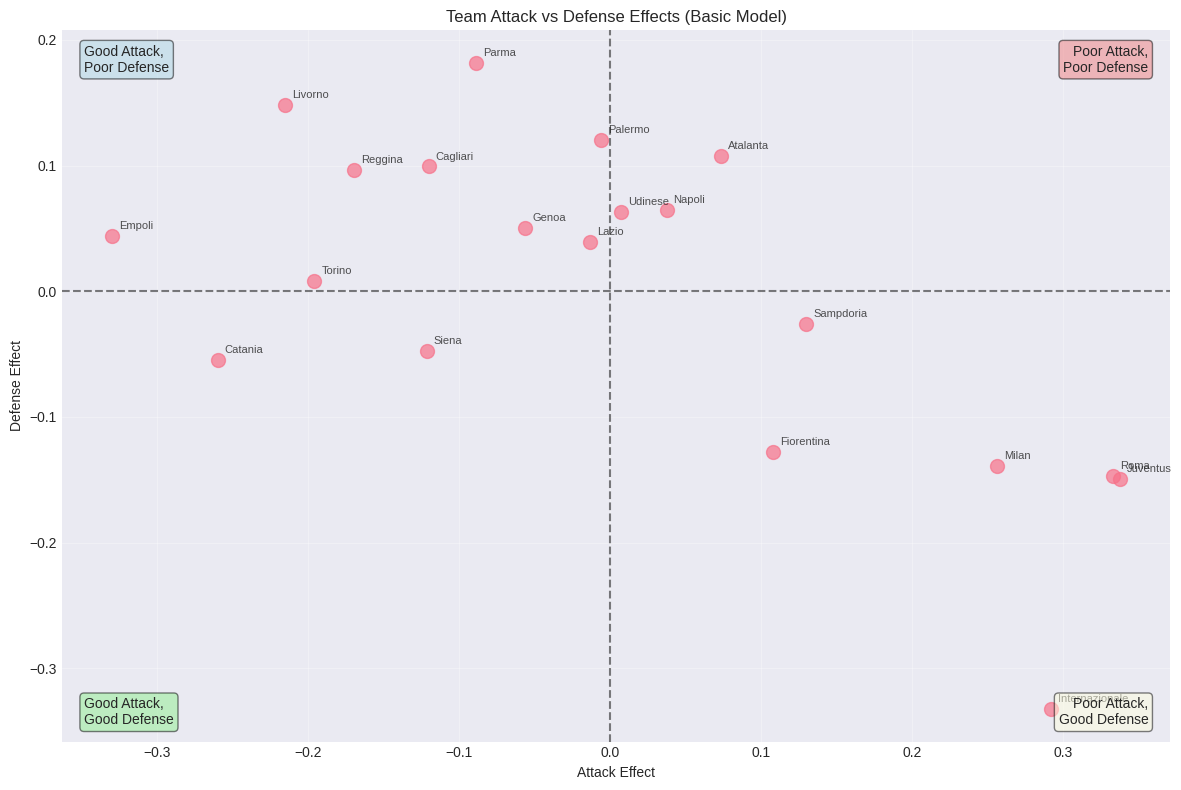


MATCH PREDICTION EXAMPLE (BASIC MODEL)
Match: Internazionale vs Milan
Expected goals: 1.69 - 0.94
Probabilities: Home 0.552, Draw 0.228, Away 0.220

FITTING MIXTURE MODEL
Fitting mixture model...


Output()

ERROR:pymc.stats.convergence:There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Mixture model fitting completed!

MIXTURE MODEL COMPREHENSIVE SUMMARY

MIXTURE MODEL SUMMARY

HOME ADVANTAGE EFFECT:
Mean: 0.3498
95% CI: [0.2433, 0.4327]
Interpretation: Home teams score exp(0.3498) = 1.419x more goals on average

TEAM EFFECTS:

Top 5 Attack (most goals scored):
          team  att_mean  att_q025  att_q975
      Juventus  0.348172  0.128494  0.573768
          Roma  0.335465  0.126060  0.565228
Internazionale  0.300906  0.103116  0.515983
         Milan  0.236080 -0.028640  0.465030
    Fiorentina  0.130152 -0.104283  0.350104

Top 5 Defense (fewest goals conceded - most negative values):
          team  def_mean  def_q025  def_q975
Internazionale -0.438281 -0.787120 -0.098010
         Milan -0.176904 -0.493667  0.099419
          Roma -0.171294 -0.434676  0.086360
      Juventus -0.132495 -0.414724  0.080165
    Fiorentina -0.110971 -0.516378  0.133958

Bottom 5 Attack (fewest goals scored):
   team  att_mean  att_q025  att_q975
 Empoli -0.306820 -0.639391 -0.037183


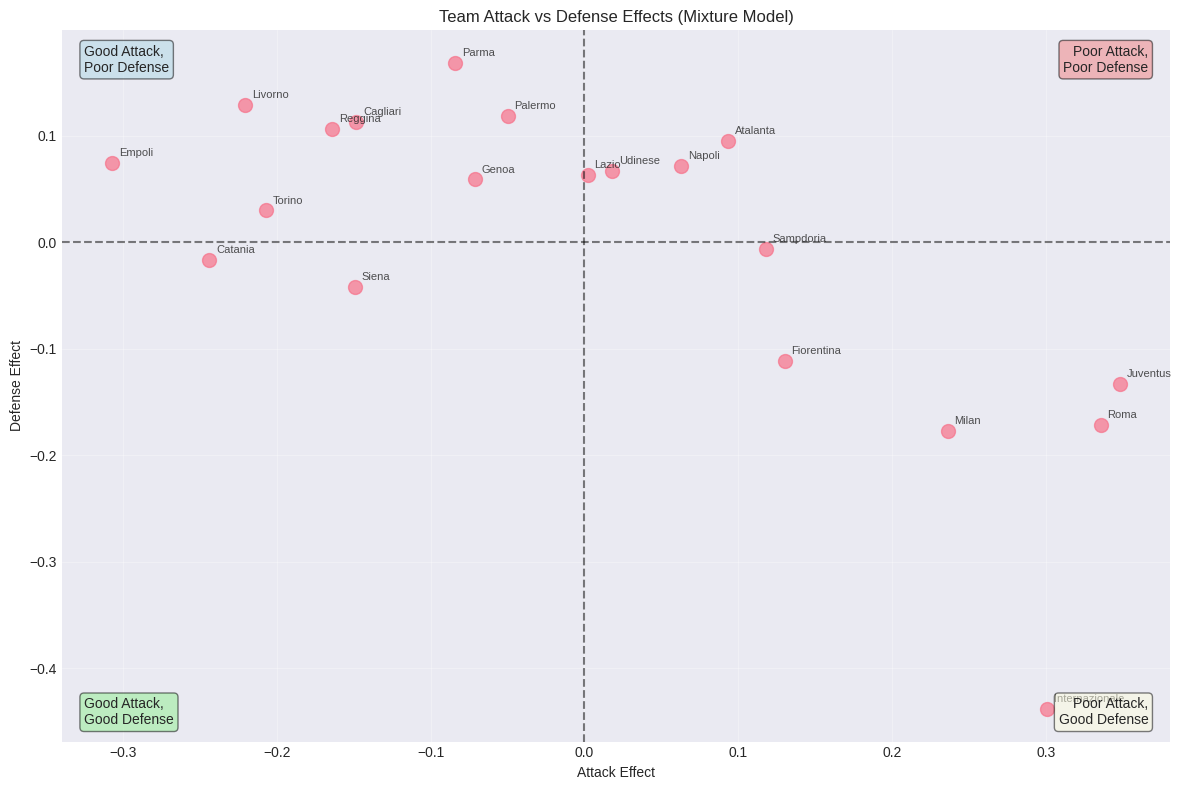


MATCH PREDICTION EXAMPLE (MIXTURE MODEL)
Match: Internazionale vs Milan
Expected goals: 1.64 - 0.84
Probabilities: Home 0.553, Draw 0.242, Away 0.205


In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class BayesianFootballModel:
    """
    Bayesian hierarchical model for football match prediction
    Based on Baio & Blangiardo (2010) paper
    """

    def __init__(self, data_file):
        """Initialize the model with data"""
        print(f"Initializing model with data file: {data_file}")

        # Initialize model attributes first (but not data attributes)
        self.basic_model = None
        self.mixture_model = None
        self.basic_trace = None
        self.mixture_trace = None

        try:
            self.data = self.load_and_prepare_data(data_file)
            print("✓ Model initialization completed successfully")
            print(f"✓ Final check - n_games: {self.n_games}, n_teams: {self.n_teams}")
        except Exception as e:
            print(f"✗ Error during model initialization: {e}")
            print("Please check that the data file exists and has the correct format")
            raise

    def load_and_prepare_data(self, data_file):
        """Load and prepare the football data"""
        # Read the Excel file
        df = pd.read_excel('/content/final dataset 2007-08.xlsx')

        # Clean column names
        df.columns = df.columns.str.strip()

        print(f"Original data shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Create team mappings
        all_teams = pd.concat([
            df['hometeam_name'],
            df['awayteam_name']
        ]).unique()

        team_to_id = {team: i for i, team in enumerate(sorted(all_teams))}
        id_to_team = {i: team for team, i in team_to_id.items()}

        # Map team names to consecutive IDs (0-based)
        df['home_team_idx'] = df['hometeam_name'].map(team_to_id)
        df['away_team_idx'] = df['awayteam_name'].map(team_to_id)

        # Check for any mapping issues
        if df['home_team_idx'].isna().any() or df['away_team_idx'].isna().any():
            print("Warning: Some teams could not be mapped!")
            print("Home team mapping issues:", df[df['home_team_idx'].isna()]['hometeam_name'].unique())
            print("Away team mapping issues:", df[df['away_team_idx'].isna()]['awayteam_name'].unique())

        # Store team information
        self.teams = sorted(all_teams)
        self.n_teams = len(self.teams)
        self.n_games = len(df)

        print(f"Data loaded: {self.n_games} games, {self.n_teams} teams")
        print(f"Teams: {self.teams}")

        # Verify no None values
        print(f"n_games type: {type(self.n_games)}, value: {self.n_games}")
        print(f"n_teams type: {type(self.n_teams)}, value: {self.n_teams}")

        return df

    def build_basic_model(self):
        """Build the basic hierarchical model from Section 2 of the paper"""

        # Check if data is properly loaded
        if self.n_games is None or self.n_teams is None:
            raise ValueError("Data not properly loaded. Please check the data file and team mappings.")

        print(f"Building model with {self.n_games} games and {self.n_teams} teams")

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        # Verify data integrity
        print(f"Home team indices range: {home_team_idx.min()} to {home_team_idx.max()}")
        print(f"Away team indices range: {away_team_idx.min()} to {away_team_idx.max()}")
        print(f"Goals range - Home: {y1_data.min()} to {y1_data.max()}, Away: {y2_data.min()} to {y2_data.max()}")

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Hyperparameters for attack and defense effects
            mu_att = pm.Normal("mu_att", mu=0, sigma=10)
            mu_def = pm.Normal("mu_def", mu=0, sigma=10)
            tau_att = pm.Gamma("tau_att", alpha=0.1, beta=0.1)
            tau_def = pm.Gamma("tau_def", alpha=0.1, beta=0.1)

            # Team-specific attack and defense effects (before centering)
            att_star = pm.Normal("att_star", mu=mu_att, sigma=1/pt.sqrt(tau_att), shape=self.n_teams)
            def_star = pm.Normal("def_star", mu=mu_def, sigma=1/pt.sqrt(tau_def), shape=self.n_teams)

            # Sum-to-zero constraint (centering)
            att = pm.Deterministic("att", att_star - pt.mean(att_star))
            def_ = pm.Deterministic("def", def_star - pt.mean(def_star))

            # Create indicator matrices for team assignments
            print("Creating indicator matrices...")
            home_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))
            away_team_matrix = np.zeros((int(self.n_games), int(self.n_teams)))

            for i in range(int(self.n_games)):
                home_team_matrix[i, int(home_team_idx[i])] = 1
                away_team_matrix[i, int(away_team_idx[i])] = 1

            print("Converting to PyTensor constants...")
            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att)
            away_att_effects = pt.dot(away_team_matrix, att)
            home_def_effects = pt.dot(home_team_matrix, def_)
            away_def_effects = pt.dot(away_team_matrix, def_)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        print("Model built successfully!")
        self.basic_model = model
        return model

    def build_mixture_model(self):
        """Build the mixture model from Section 4 of the paper"""

        # Prepare data arrays
        home_team_idx = self.data['home_team_idx'].values
        away_team_idx = self.data['away_team_idx'].values
        y1_data = self.data['y1'].values
        y2_data = self.data['y2'].values

        with pm.Model() as model:
            # Home advantage parameter
            home_advantage = pm.Normal("home_advantage", mu=0, sigma=10)

            # Mixture parameters for each team
            # Prior probabilities for group membership (3 groups: bottom, mid, top)
            alpha_att = np.ones(3)  # Uniform prior over groups
            alpha_def = np.ones(3)

            p_att = pm.Dirichlet("p_att", a=alpha_att, shape=(self.n_teams, 3))
            p_def = pm.Dirichlet("p_def", a=alpha_def, shape=(self.n_teams, 3))

            # Group assignment for each team
            grp_att = pm.Categorical("grp_att", p=p_att, shape=self.n_teams)
            grp_def = pm.Categorical("grp_def", p=p_def, shape=self.n_teams)

            # Group-specific parameters
            # Group 1: Bottom teams (poor attack, poor defense)
            mu_att_1 = pm.TruncatedNormal("mu_att_1", mu=0, sigma=10, lower=-3, upper=0)
            mu_def_1 = pm.TruncatedNormal("mu_def_1", mu=0, sigma=10, lower=0, upper=3)
            tau_att_1 = pm.Gamma("tau_att_1", alpha=0.01, beta=0.01)
            tau_def_1 = pm.Gamma("tau_def_1", alpha=0.01, beta=0.01)

            # Group 2: Mid-table teams (average)
            mu_att_2 = pt.constant(0.0)
            mu_def_2 = pt.constant(0.0)
            tau_att_2 = pm.Gamma("tau_att_2", alpha=0.01, beta=0.01)
            tau_def_2 = pm.Gamma("tau_def_2", alpha=0.01, beta=0.01)

            # Group 3: Top teams (good attack, good defense)
            mu_att_3 = pm.TruncatedNormal("mu_att_3", mu=0, sigma=10, lower=0, upper=3)
            mu_def_3 = pm.TruncatedNormal("mu_def_3", mu=0, sigma=10, lower=-3, upper=0)
            tau_att_3 = pm.Gamma("tau_att_3", alpha=0.01, beta=0.01)
            tau_def_3 = pm.Gamma("tau_def_3", alpha=0.01, beta=0.01)

            # Stack parameters
            mu_att_groups = pt.stack([mu_att_1, mu_att_2, mu_att_3])
            mu_def_groups = pt.stack([mu_def_1, mu_def_2, mu_def_3])
            tau_att_groups = pt.stack([tau_att_1, tau_att_2, tau_att_3])
            tau_def_groups = pt.stack([tau_def_1, tau_def_2, tau_def_3])

            # Team-specific effects using Normal distribution (simplified from t-distribution)
            # We'll use a simpler approach due to indexing complexity with StudentT and mixture
            att_raw = pm.Normal("att_raw", mu=0, sigma=1, shape=self.n_teams)
            def_raw = pm.Normal("def_raw", mu=0, sigma=1, shape=self.n_teams)

            # Scale by group-specific parameters
            att_scaled = []
            def_scaled = []

            for t in range(self.n_teams):
                att_mu_t = pt.switch(pt.eq(grp_att[t], 0), mu_att_groups[0],
                                   pt.switch(pt.eq(grp_att[t], 1), mu_att_groups[1], mu_att_groups[2]))
                att_tau_t = pt.switch(pt.eq(grp_att[t], 0), tau_att_groups[0],
                                    pt.switch(pt.eq(grp_att[t], 1), tau_att_groups[1], tau_att_groups[2]))

                def_mu_t = pt.switch(pt.eq(grp_def[t], 0), mu_def_groups[0],
                                   pt.switch(pt.eq(grp_def[t], 1), mu_def_groups[1], mu_def_groups[2]))
                def_tau_t = pt.switch(pt.eq(grp_def[t], 0), tau_def_groups[0],
                                    pt.switch(pt.eq(grp_def[t], 1), tau_def_groups[1], tau_def_groups[2]))

                att_t = att_mu_t + att_raw[t] / pt.sqrt(att_tau_t)
                def_t = def_mu_t + def_raw[t] / pt.sqrt(def_tau_t)

                att_scaled.append(att_t)
                def_scaled.append(def_t)

            att = pt.stack(att_scaled)
            def_ = pt.stack(def_scaled)

            # Apply sum-to-zero constraint
            att_centered = pm.Deterministic("att_centered", att - pt.mean(att))
            def_centered = pm.Deterministic("def_centered", def_ - pt.mean(def_))

            # Create indicator matrices for team assignments
            home_team_matrix = np.zeros((self.n_games, self.n_teams))
            away_team_matrix = np.zeros((self.n_games, self.n_teams))

            for i in range(self.n_games):
                home_team_matrix[i, home_team_idx[i]] = 1
                away_team_matrix[i, away_team_idx[i]] = 1

            # Convert to PyTensor constants
            home_team_matrix = pt.constant(home_team_matrix)
            away_team_matrix = pt.constant(away_team_matrix)

            # Calculate team-specific effects for each game using matrix multiplication
            home_att_effects = pt.dot(home_team_matrix, att_centered)
            away_att_effects = pt.dot(away_team_matrix, att_centered)
            home_def_effects = pt.dot(home_team_matrix, def_centered)
            away_def_effects = pt.dot(away_team_matrix, def_centered)

            # Scoring intensities
            log_theta1 = home_advantage + home_att_effects + away_def_effects
            log_theta2 = away_att_effects + home_def_effects

            theta1 = pm.Deterministic("theta1", pt.exp(log_theta1))
            theta2 = pm.Deterministic("theta2", pt.exp(log_theta2))

            # Likelihood
            y1 = pm.Poisson("y1", mu=theta1, observed=y1_data)
            y2 = pm.Poisson("y2", mu=theta2, observed=y2_data)

        self.mixture_model = model
        return model

    def fit_basic_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the basic hierarchical model"""
        print("Fitting basic hierarchical model...")

        if self.basic_model is None:
            self.build_basic_model()

        with self.basic_model:
            # Sample from posterior
            self.basic_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Higher target acceptance for better sampling
            )

            # Sample posterior predictive
            with self.basic_model:
                self.basic_trace.extend(pm.sample_posterior_predictive(self.basic_trace))

        print("Basic model fitting completed!")
        return self.basic_trace

    def fit_mixture_model(self, draws=2000, tune=1000, chains=2, cores=1):
        """Fit the mixture model"""
        print("Fitting mixture model...")

        if self.mixture_model is None:
            self.build_mixture_model()

        with self.mixture_model:
            # Sample from posterior with simplified parameters
            self.mixture_trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                random_seed=42,
                return_inferencedata=True,
                target_accept=0.9  # Slightly lower target acceptance to avoid issues
            )

            # Sample posterior predictive
            with self.mixture_model:
                self.mixture_trace.extend(pm.sample_posterior_predictive(self.mixture_trace))

        print("Mixture model fitting completed!")
        return self.mixture_trace

    def get_home_advantage_summary(self, model_type='basic'):
        """Get summary statistics for home advantage effect"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Extract home advantage samples
        home_adv_samples = trace.posterior['home_advantage']

        # Calculate summary statistics
        home_summary = {
            'parameter': 'home_advantage',
            'mean': float(home_adv_samples.mean()),
            'median': float(home_adv_samples.median()),
            'std': float(home_adv_samples.std()),
            'q025': float(home_adv_samples.quantile(0.025)),
            'q975': float(home_adv_samples.quantile(0.975))
        }

        return home_summary

    def plot_team_effects(self, model_type='basic'):
        """Plot attack vs defense effects for each team"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return

        # Get posterior means
        if model_type == 'basic':
            att_means = trace.posterior['att'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def'].mean(dim=['chain', 'draw']).values
        else:
            att_means = trace.posterior['att_centered'].mean(dim=['chain', 'draw']).values
            def_means = trace.posterior['def_centered'].mean(dim=['chain', 'draw']).values

        # Create plot
        plt.figure(figsize=(12, 8))
        plt.scatter(att_means, def_means, s=100, alpha=0.7)

        # Add team labels
        for i, team in enumerate(self.teams):
            plt.annotate(team, (att_means[i], def_means[i]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

        plt.xlabel('Attack Effect')
        plt.ylabel('Defense Effect')
        plt.title(f'Team Attack vs Defense Effects ({model_type.title()} Model)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)

        # Add quadrant labels
        plt.text(0.02, 0.98, 'Good Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        plt.text(0.98, 0.98, 'Poor Attack,\nPoor Defense',
                transform=plt.gca().transAxes, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
        plt.text(0.02, 0.02, 'Good Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        plt.text(0.98, 0.02, 'Poor Attack,\nGood Defense',
                transform=plt.gca().transAxes, va='bottom', ha='right',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def get_team_summary(self, model_type='basic'):
        """Get summary statistics for team effects"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get parameter names
        if model_type == 'basic':
            att_param = 'att'
            def_param = 'def'
        else:
            att_param = 'att_centered'
            def_param = 'def_centered'

        # Extract posterior samples
        att_samples = trace.posterior[att_param]
        def_samples = trace.posterior[def_param]

        # Calculate summary statistics
        summary_data = []
        for i, team in enumerate(self.teams):
            # Handle different indexing based on parameter dimensions
            if len(att_samples.dims) == 3:  # chain, draw, team
                att_team_samples = att_samples.isel({list(att_samples.dims)[2]: i})
                def_team_samples = def_samples.isel({list(def_samples.dims)[2]: i})
            else:  # Different structure
                att_team_samples = att_samples[..., i]
                def_team_samples = def_samples[..., i]

            att_mean = float(att_team_samples.mean())
            att_q025 = float(att_team_samples.quantile(0.025))
            att_q975 = float(att_team_samples.quantile(0.975))

            def_mean = float(def_team_samples.mean())
            def_q025 = float(def_team_samples.quantile(0.025))
            def_q975 = float(def_team_samples.quantile(0.975))

            summary_data.append({
                'team': team,
                'att_mean': att_mean,
                'att_q025': att_q025,
                'att_q975': att_q975,
                'def_mean': def_mean,
                'def_q025': def_q025,
                'def_q975': def_q975
            })

        summary_df = pd.DataFrame(summary_data)

        # Sort by attack effect (descending)
        summary_df = summary_df.sort_values('att_mean', ascending=False)

        return summary_df

    def print_model_summary(self, model_type='basic'):
        """Print comprehensive model summary including home advantage"""

        print(f"\n{model_type.upper()} MODEL SUMMARY")
        print("=" * 60)

        # Home advantage
        home_summary = self.get_home_advantage_summary(model_type)
        if home_summary:
            print(f"\nHOME ADVANTAGE EFFECT:")
            print(f"Mean: {home_summary['mean']:.4f}")
            print(f"95% CI: [{home_summary['q025']:.4f}, {home_summary['q975']:.4f}]")
            print(f"Interpretation: Home teams score exp({home_summary['mean']:.4f}) = {np.exp(home_summary['mean']):.3f}x more goals on average")

        # Team effects
        print(f"\nTEAM EFFECTS:")
        team_summary = self.get_team_summary(model_type)
        if team_summary is not None:
            print("\nTop 5 Attack (most goals scored):")
            print(team_summary.head()[['team', 'att_mean', 'att_q025', 'att_q975']].to_string(index=False))

            print(f"\nTop 5 Defense (fewest goals conceded - most negative values):")
            defense_sorted = team_summary.sort_values('def_mean', ascending=True)
            print(defense_sorted.head()[['team', 'def_mean', 'def_q025', 'def_q975']].to_string(index=False))

            print(f"\nBottom 5 Attack (fewest goals scored):")
            attack_sorted = team_summary.sort_values('att_mean', ascending=True)
            print(attack_sorted.head()[['team', 'att_mean', 'att_q025', 'att_q975']].to_string(index=False))

            print(f"\nBottom 5 Defense (most goals conceded - most positive values):")
            print(defense_sorted.tail()[['team', 'def_mean', 'def_q025', 'def_q975']].to_string(index=False))

    def predict_match(self, home_team, away_team, model_type='basic', n_samples=1000):
        """Predict the outcome of a specific match"""

        trace = self.basic_trace if model_type == 'basic' else self.mixture_trace

        if trace is None:
            print(f"Please fit the {model_type} model first!")
            return None

        # Get team indices
        home_idx = self.teams.index(home_team)
        away_idx = self.teams.index(away_team)

        # Get parameter samples
        home_adv_samples = trace.posterior['home_advantage'].values.flatten()

        if model_type == 'basic':
            att_samples = trace.posterior['att'].values
            def_samples = trace.posterior['def'].values
        else:
            att_samples = trace.posterior['att_centered'].values
            def_samples = trace.posterior['def_centered'].values

        # Reshape samples for easier indexing
        att_flat = att_samples.reshape(-1, att_samples.shape[-1])
        def_flat = def_samples.reshape(-1, def_samples.shape[-1])
        home_adv_flat = home_adv_samples.flatten()

        # Take only n_samples
        n_available = min(len(home_adv_flat), len(att_flat))
        n_use = min(n_samples, n_available)

        # Calculate scoring intensities
        theta1_samples = np.exp(home_adv_flat[:n_use] +
                               att_flat[:n_use, home_idx] +
                               def_flat[:n_use, away_idx])

        theta2_samples = np.exp(att_flat[:n_use, away_idx] +
                               def_flat[:n_use, home_idx])

        # Generate predictions
        home_goals = np.random.poisson(theta1_samples)
        away_goals = np.random.poisson(theta2_samples)

        # Calculate probabilities
        home_win = np.mean(home_goals > away_goals)
        draw = np.mean(home_goals == away_goals)
        away_win = np.mean(home_goals < away_goals)

        # Expected goals
        exp_home_goals = np.mean(theta1_samples)
        exp_away_goals = np.mean(theta2_samples)

        return {
            'home_team': home_team,
            'away_team': away_team,
            'expected_home_goals': exp_home_goals,
            'expected_away_goals': exp_away_goals,
            'prob_home_win': home_win,
            'prob_draw': draw,
            'prob_away_win': away_win,
            'home_goals_samples': home_goals,
            'away_goals_samples': away_goals
        }


# Usage example
if __name__ == "__main__":
    # Initialize the model with your data file
    # Replace 'final dataset 200708.xlsx' with the actual file path
    model = BayesianFootballModel('final dataset 200708.xlsx')

    # Fit the basic model first (simpler and more stable)
    print("=" * 50)
    print("FITTING BASIC MODEL")
    print("=" * 50)
    basic_trace = model.fit_basic_model(draws=1000, tune=500, chains=2)

    # Get comprehensive model summary including home advantage
    print("\n" + "=" * 50)
    print("BASIC MODEL COMPREHENSIVE SUMMARY")
    print("=" * 50)
    model.print_model_summary('basic')

    # Plot team effects
    model.plot_team_effects('basic')

    # Example prediction
    print("\n" + "=" * 50)
    print("MATCH PREDICTION EXAMPLE (BASIC MODEL)")
    print("=" * 50)
    prediction = model.predict_match('Internazionale', 'Milan', 'basic')
    if prediction:
        print(f"Match: {prediction['home_team']} vs {prediction['away_team']}")
        print(f"Expected goals: {prediction['expected_home_goals']:.2f} - {prediction['expected_away_goals']:.2f}")
        print(f"Probabilities: Home {prediction['prob_home_win']:.3f}, Draw {prediction['prob_draw']:.3f}, Away {prediction['prob_away_win']:.3f}")

    # Uncomment the following if you want to try the mixture model:
    # Note: The mixture model is more complex and may take longer to fit

    print("\n" + "=" * 50)
    print("FITTING MIXTURE MODEL")
    print("=" * 50)
    try:
        mixture_trace = model.fit_mixture_model(draws=500, tune=300, chains=2)  # Reduced draws for faster testing

        print("\n" + "=" * 50)
        print("MIXTURE MODEL COMPREHENSIVE SUMMARY")
        print("=" * 50)
        model.print_model_summary('mixture')

        model.plot_team_effects('mixture')

        # Example prediction with mixture model
        print("\n" + "=" * 50)
        print("MATCH PREDICTION EXAMPLE (MIXTURE MODEL)")
        print("=" * 50)
        prediction_mix = model.predict_match('Internazionale', 'Milan', 'mixture')
        if prediction_mix:
            print(f"Match: {prediction_mix['home_team']} vs {prediction_mix['away_team']}")
            print(f"Expected goals: {prediction_mix['expected_home_goals']:.2f} - {prediction_mix['expected_away_goals']:.2f}")
            print(f"Probabilities: Home {prediction_mix['prob_home_win']:.3f}, Draw {prediction_mix['prob_draw']:.3f}, Away {prediction_mix['prob_away_win']:.3f}")

    except Exception as e:
        print(f"Mixture model failed: {e}")
        print("This is expected as mixture models are complex. The basic model results above are still valid.")